# Predictive model for passengers - Team 86

This notebook develops the XGBoost models to estimate the future flow of passengers through land terminals. There is a model for each terminal. In the case of evidence of overfitting, it was regularized by means of the optimal adjustment of the hyperparameters of the model (Random Search).

In [2]:
#Import the libraries, previously you should install the packages, relate in the document requirements.txt

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import datatable as dt
import xgboost as xgb
import datetime as dt


from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

In [3]:
# Load the clean dataset
df = pd.read_csv('data_clean.csv', parse_dates = ['FECHA_DESPACHO'])

# TT BOGOTA SALITRE

In [3]:
# 1. Data wrangling

# a. Select the terminal

t_bogota_salitre=df[df['TERMINAL'] =='T.T. DE BOGOTÁ SALITRE']

# b. Select the main features for the model
# Features such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_bogota_salitre=t_bogota_salitre.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                               'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_bogota_salitre = data_bogota_salitre.rename(columns={'sum':'PASAJEROS'})

# c. Create new features

# holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_bogota_salitre['FESTIVOS'] = data_bogota_salitre['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

# features date
data_bogota_salitre['dayofweek'] = data_bogota_salitre['FECHA_DESPACHO'].dt.dayofweek
data_bogota_salitre['quarter'] = data_bogota_salitre['FECHA_DESPACHO'].dt.quarter
data_bogota_salitre['month'] = data_bogota_salitre['FECHA_DESPACHO'].dt.month
data_bogota_salitre['year'] = data_bogota_salitre['FECHA_DESPACHO'].dt.year
data_bogota_salitre['dayofyear'] = data_bogota_salitre['FECHA_DESPACHO'].dt.dayofyear
data_bogota_salitre['dayofmonth'] = data_bogota_salitre['FECHA_DESPACHO'].dt.day
data_bogota_salitre['weekofyear'] = data_bogota_salitre['FECHA_DESPACHO'].dt.weekofyear

# mobility restrictions

data_bogota_salitre["restriccion"] = np.where(data_bogota_salitre['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_bogota_salitre['FECHA_DESPACHO'] > '2020-03-26')&(data_bogota_salitre['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_bogota_salitre['FECHA_DESPACHO'] >='2020-09-01')&(data_bogota_salitre['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_bogota_salitre['FECHA_DESPACHO'] >='2021-03-01')&(data_bogota_salitre['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# travel destination

data_bogota_salitre["Depto_Municipio"]=data_bogota_salitre['DEPARTAMENTO_DESTINO']+' '+data_bogota_salitre['MUNICIPIO_DESTINO']

<ipython-input-3-5a449d8e9c83>:32: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_bogota_salitre['weekofyear'] = data_bogota_salitre['FECHA_DESPACHO'].dt.weekofyear


In [ ]:
# 2. Model

# Set var x and var y
x_bogota_salitre=data_bogota_salitre.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_bogota_salitre=data_bogota_salitre['PASAJEROS']

# Encoding categorical data
x_bogota_salitre_encoded=pd.get_dummies(x_bogota_salitre, columns=["Depto_Municipio"])

# Data training and data test
x_train_bogota_salitre, x_test_bogota_salitre, y_train_bogota_salitre, y_test_bogota_salitre = train_test_split(x_bogota_salitre_encoded,y_bogota_salitre,test_size=0.2,random_state=42)
print(x_train_bogota_salitre.shape)
print(x_test_bogota_salitre.shape)

# define model
model_bogota_salitre = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_bogota_salitre.fit(x_train_bogota_salitre, y_train_bogota_salitre)

(517721, 266)
(129431, 266)


R2 train 0.796249764886902
MSE train 108.38189517167854
RMSE train 10.410662571214118
R2 test 0.7833207628879255
MSE test 116.4624541214553
RMSE test 10.791777153066834
Percentil 99 Passengers 111.0


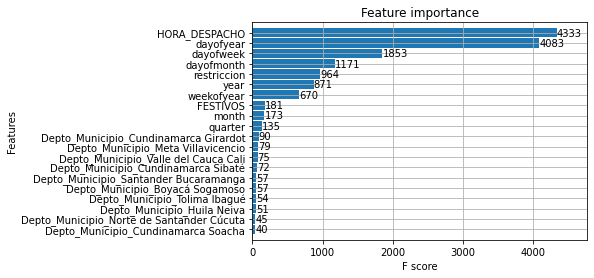

In [5]:
# 3. Evaluate the model

# Feature importances
%matplotlib inline
xgb.plot_importance(model_bogota_salitre, ax=plt.gca(),max_num_features=20, height = 0.9)

# evaluation metrics
predtrain_bogota_salitre = model_bogota_salitre.predict(x_train_bogota_salitre)
print('R2 train',r2_score(y_train_bogota_salitre,predtrain_bogota_salitre))
print('MSE train',mean_squared_error(y_train_bogota_salitre,predtrain_bogota_salitre))
print('RMSE train',np.sqrt(mean_squared_error(y_train_bogota_salitre,predtrain_bogota_salitre)))

predtest_bogota_salitre=model_bogota_salitre.predict(x_test_bogota_salitre)
print('R2 test',r2_score(y_test_bogota_salitre,predtest_bogota_salitre))
print('MSE test',mean_squared_error(y_test_bogota_salitre,predtest_bogota_salitre))
print('RMSE test',np.sqrt(mean_squared_error(y_test_bogota_salitre,predtest_bogota_salitre)))

print('Percentil 99 Passengers',np.percentile(data_bogota_salitre['PASAJEROS'],99))

In [6]:
# Export model for dash / plotly
import pickle
file_name = "xgb_model_bogota_salitre.pkl"

# save
pickle.dump(model_bogota_salitre, open(file_name, "wb"))

# T.T. DE BUCARAMANGA

In [4]:
# 1. Data wrangling

# a. Select the terminal

t_bucaramanga=df[df['TERMINAL'] =='T.T. DE BUCARAMANGA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_bucaramanga=t_bucaramanga.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_bucaramanga = data_bucaramanga.rename(columns={'sum':'PASAJEROS'})

# c. Create new features

# holidays

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_bucaramanga['FESTIVOS'] = data_bucaramanga['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

#Features date
data_bucaramanga['dayofweek'] = data_bucaramanga['FECHA_DESPACHO'].dt.dayofweek
data_bucaramanga['quarter'] = data_bucaramanga['FECHA_DESPACHO'].dt.quarter
data_bucaramanga['month'] = data_bucaramanga['FECHA_DESPACHO'].dt.month
data_bucaramanga['year'] = data_bucaramanga['FECHA_DESPACHO'].dt.year
data_bucaramanga['dayofyear'] = data_bucaramanga['FECHA_DESPACHO'].dt.dayofyear
data_bucaramanga['dayofmonth'] = data_bucaramanga['FECHA_DESPACHO'].dt.day
data_bucaramanga['weekofyear'] = data_bucaramanga['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions

data_bucaramanga["restriccion"] = np.where(data_bucaramanga['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_bucaramanga['FECHA_DESPACHO'] > '2020-03-26')&(data_bucaramanga['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_bucaramanga['FECHA_DESPACHO'] >='2020-09-01')&(data_bucaramanga['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_bucaramanga['FECHA_DESPACHO'] >='2021-03-01')&(data_bucaramanga['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination

data_bucaramanga["Depto_Municipio"]=data_bucaramanga['DEPARTAMENTO_DESTINO']+' '+data_bucaramanga['MUNICIPIO_DESTINO']


<ipython-input-4-41d1bd519471>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_bucaramanga['weekofyear'] = data_bucaramanga['FECHA_DESPACHO'].dt.weekofyear


In [5]:
# 2. Model

# Set var x, var y
x_bucaramanga=data_bucaramanga.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_bucaramanga=data_bucaramanga['PASAJEROS']

# Encoding categorical data
x_bucaramanga_encoded=pd.get_dummies(x_bucaramanga, columns=["Depto_Municipio"])

# Data training and data test
x_train_bucaramanga, x_test_bucaramanga, y_train_bucaramanga, y_test_bucaramanga = train_test_split(x_bucaramanga_encoded,y_bucaramanga,test_size=0.2,random_state=42)
print(x_train_bucaramanga.shape)
print(x_test_bucaramanga.shape)

# define model
model_bucaramanga = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_bucaramanga.fit(x_train_bucaramanga, y_train_bucaramanga)

(136800, 67)
(34201, 67)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.8572062975744512
MSE train 58.7033760757781
RMSE train 7.661812845259149
Mean train 9.0
R2 test 0.8006327119091615
MSE test 79.3480198704061
RMSE test 8.907750550526552
Mean test 9.0
Percentil 99 Passengers 106.0


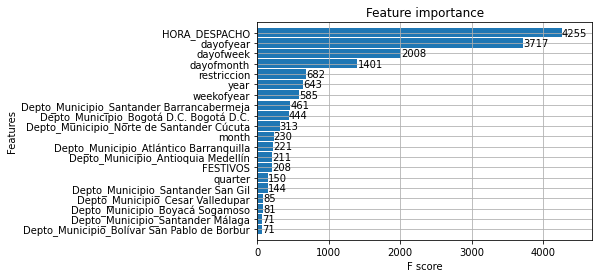

In [6]:
# Evaluate the model

# Feature importances
xgb.plot_importance(model_bucaramanga, ax=plt.gca(),max_num_features=20, height = 0.9)

# metrics

predtrain_bucaramanga = model_bucaramanga.predict(x_train_bucaramanga)
print('R2 train',r2_score(y_train_bucaramanga,predtrain_bucaramanga))
print('MSE train',mean_squared_error(y_train_bucaramanga,predtrain_bucaramanga))
print('RMSE train',np.sqrt(mean_squared_error(y_train_bucaramanga,predtrain_bucaramanga)))
print('Mean train',np.median(y_train_bucaramanga))

predtest_bucaramanga=model_bucaramanga.predict(x_test_bucaramanga)
print('R2 test',r2_score(y_test_bucaramanga,predtest_bucaramanga))
print('MSE test',mean_squared_error(y_test_bucaramanga,predtest_bucaramanga))
print('RMSE test',np.sqrt(mean_squared_error(y_test_bucaramanga,predtest_bucaramanga)))
print('Mean test',np.median(y_test_bucaramanga))

print('Percentil 99 Passengers',np.percentile(data_bucaramanga['PASAJEROS'],99))

In [10]:
# Export model for dash / plotly

file_name = "xgb_model_bucaramanga.pkl"

# save
pickle.dump(model_bucaramanga, open(file_name, "wb"))

# T.T. DE HONDA

In [11]:
# 1. Data wrangling

# a. Select the terminal

t_honda=df[df['TERMINAL'] =='T.T. DE HONDA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_honda=t_honda.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_honda = data_honda.rename(columns={'sum':'PASAJEROS'})

#Create new features

#Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_honda['FESTIVOS'] = data_honda['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

#Features date
data_honda['dayofweek'] = data_honda['FECHA_DESPACHO'].dt.dayofweek
data_honda['quarter'] = data_honda['FECHA_DESPACHO'].dt.quarter
data_honda['month'] = data_honda['FECHA_DESPACHO'].dt.month
data_honda['year'] = data_honda['FECHA_DESPACHO'].dt.year
data_honda['dayofyear'] = data_honda['FECHA_DESPACHO'].dt.dayofyear
data_honda['dayofmonth'] = data_honda['FECHA_DESPACHO'].dt.day
data_honda['weekofyear'] = data_honda['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions

data_honda["restriccion"] = np.where(data_honda['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_honda['FECHA_DESPACHO'] > '2020-03-26')&(data_honda['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_honda['FECHA_DESPACHO'] >='2020-09-01')&(data_honda['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_honda['FECHA_DESPACHO'] >='2021-03-01')&(data_honda['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination
data_honda["Depto_Municipio"]=data_honda['DEPARTAMENTO_DESTINO']+' '+data_honda['MUNICIPIO_DESTINO']


<ipython-input-11-b5b0d24a221b>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_honda['weekofyear'] = data_honda['FECHA_DESPACHO'].dt.weekofyear


In [12]:
# Model

# Set x, y
x_honda=data_honda.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_honda=data_honda['PASAJEROS']

# Encoding categorical data
x_honda_encoded=pd.get_dummies(x_honda, columns=["Depto_Municipio"])

# Data training and data test
x_train_honda, x_test_honda, y_train_honda, y_test_honda = train_test_split(x_honda_encoded,y_honda,test_size=0.2,random_state=42)
print(x_train_honda.shape)
print(x_test_honda.shape)

# define model
model_honda = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_honda.fit(x_train_honda, y_train_honda)

(91585, 44)
(22897, 44)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.7588951640756647
MSE train 30.493471191703282
RMSE train 5.522089386428227
R2 test 0.659387110065333
MSE test 42.32980543094538
RMSE test 6.506135983127418
Percentil 99 Passengers 52.0


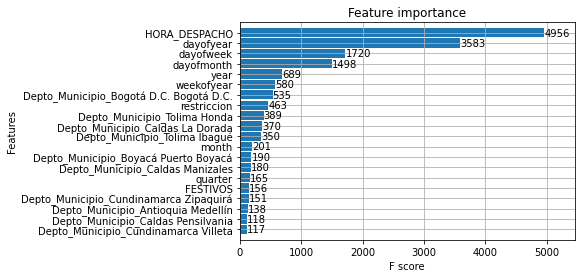

In [13]:
# Evaluate the model

#Feature importance
xgb.plot_importance(model_honda, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_honda = model_honda.predict(x_train_honda)
print('R2 train',r2_score(y_train_honda,predtrain_honda))
print('MSE train',mean_squared_error(y_train_honda,predtrain_honda))
print('RMSE train',np.sqrt(mean_squared_error(y_train_honda,predtrain_honda)))

predtest_honda=model_honda.predict(x_test_honda)
print('R2 test',r2_score(y_test_honda,predtest_honda))
print('MSE test',mean_squared_error(y_test_honda,predtest_honda))
print('RMSE test',np.sqrt(mean_squared_error(y_test_honda,predtest_honda)))

print('Percentil 99 Passengers',np.percentile(data_honda['PASAJEROS'],99))


In [14]:
# Export model for dash / plotly
file_name = "xgb_model_honda.pkl"

# save
pickle.dump(model_honda, open(file_name, "wb"))

# T.T. DE APARTADÓ

In [15]:
# 1. Data wrangling

# a. Select the terminal

t_apartado=df[df['TERMINAL'] =='T.T. DE APARTADÓ']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_apartado=t_apartado.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_apartado = data_apartado.rename(columns={'sum':'PASAJEROS'})

#Create new features

#Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_apartado['FESTIVOS'] = data_apartado['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

#Features date
data_apartado['dayofweek'] = data_apartado['FECHA_DESPACHO'].dt.dayofweek
data_apartado['quarter'] = data_apartado['FECHA_DESPACHO'].dt.quarter
data_apartado['month'] = data_apartado['FECHA_DESPACHO'].dt.month
data_apartado['year'] = data_apartado['FECHA_DESPACHO'].dt.year
data_apartado['dayofyear'] = data_apartado['FECHA_DESPACHO'].dt.dayofyear
data_apartado['dayofmonth'] = data_apartado['FECHA_DESPACHO'].dt.day
data_apartado['weekofyear'] = data_apartado['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions

data_apartado["restriccion"] = np.where(data_apartado['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_apartado['FECHA_DESPACHO'] > '2020-03-26')&(data_apartado['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_apartado['FECHA_DESPACHO'] >='2020-09-01')&(data_apartado['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_apartado['FECHA_DESPACHO'] >='2021-03-01')&(data_apartado['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination

data_apartado["Depto_Municipio"]=data_apartado['DEPARTAMENTO_DESTINO']+' '+data_apartado['MUNICIPIO_DESTINO']


<ipython-input-15-6b5f9db0a2c5>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_apartado['weekofyear'] = data_apartado['FECHA_DESPACHO'].dt.weekofyear


In [16]:
# Model
# Set var x, and var y
x_apartado=data_apartado.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_apartado=data_apartado['PASAJEROS']

# Encoding categorical data
x_apartado_encoded=pd.get_dummies(x_apartado, columns=["Depto_Municipio"])

# Data training and data test
x_train_apartado, x_test_apartado, y_train_apartado, y_test_apartado = train_test_split(x_apartado_encoded,y_apartado,test_size=0.2,random_state=42)
print(x_train_apartado.shape)
print(x_test_apartado.shape)

# define model
model_apartado = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_apartado.fit(x_train_apartado, y_train_apartado)

(41820, 22)
(10455, 22)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.9439898593283712
MSE train 207.0343809348026
RMSE train 14.388689340409105
R2 test 0.8779271115250921
MSE test 415.1837363201733
RMSE test 20.37605791904247
Percentil 99 Passengers 263.0


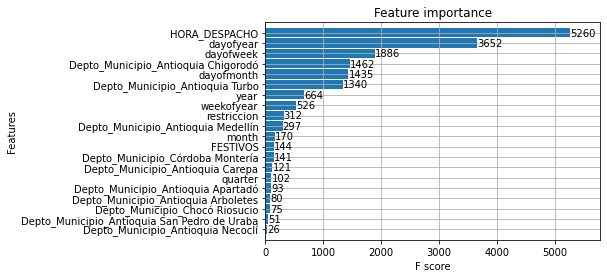

In [17]:
# Evaluate the model

#Feature importance
xgb.plot_importance(model_apartado, ax=plt.gca(),max_num_features=20, height = 0.9)

#Metrics
predtrain_apartado = model_apartado.predict(x_train_apartado)
print('R2 train',r2_score(y_train_apartado,predtrain_apartado))
print('MSE train',mean_squared_error(y_train_apartado,predtrain_apartado))
print('RMSE train',np.sqrt(mean_squared_error(y_train_apartado,predtrain_apartado)))

predtest_apartado=model_apartado.predict(x_test_apartado)
print('R2 test',r2_score(y_test_apartado,predtest_apartado))
print('MSE test',mean_squared_error(y_test_apartado,predtest_apartado))
print('RMSE test',np.sqrt(mean_squared_error(y_test_apartado,predtest_apartado)))

print('Percentil 99 Passengers',np.percentile(data_apartado['PASAJEROS'],99))


In [18]:
# Export model for dash / plotly
file_name = "xgb_model_apartado.pkl"

# save
pickle.dump(model_apartado, open(file_name, "wb"))

# T.T. DE ARMENIA

In [19]:
# 1. Data wrangling

# a. Select the terminal

t_armenia=df[df['TERMINAL'] =='T.T. DE ARMENIA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_armenia=t_armenia.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_armenia = data_armenia.rename(columns={'sum':'PASAJEROS'})

#Create new features

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_armenia['FESTIVOS'] = data_armenia['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

data_armenia['dayofweek'] = data_armenia['FECHA_DESPACHO'].dt.dayofweek
data_armenia['quarter'] = data_armenia['FECHA_DESPACHO'].dt.quarter
data_armenia['month'] = data_armenia['FECHA_DESPACHO'].dt.month
data_armenia['year'] = data_armenia['FECHA_DESPACHO'].dt.year
data_armenia['dayofyear'] = data_armenia['FECHA_DESPACHO'].dt.dayofyear
data_armenia['dayofmonth'] = data_armenia['FECHA_DESPACHO'].dt.day
data_armenia['weekofyear'] = data_armenia['FECHA_DESPACHO'].dt.weekofyear

# se crea una nueva variable que da cuenta de restricciones a la movilidad, 3 corresponde al valor sin restricciones, 0 alta
# restricción de movilidad que es el de periodos iniciales a la pandemia y 1 y 2 periodos posteriores siendo 2 el periodo después
# del inicio de vacunación

data_armenia["restriccion"] = np.where(data_armenia['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_armenia['FECHA_DESPACHO'] > '2020-03-26')&(data_armenia['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_armenia['FECHA_DESPACHO'] >='2020-09-01')&(data_armenia['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_armenia['FECHA_DESPACHO'] >='2021-03-01')&(data_armenia['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Se unicia departamento y municipio de destino en una sola variable

data_armenia["Depto_Municipio"]=data_armenia['DEPARTAMENTO_DESTINO']+' '+data_armenia['MUNICIPIO_DESTINO']


<ipython-input-19-79d88d6596a6>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_armenia['weekofyear'] = data_armenia['FECHA_DESPACHO'].dt.weekofyear


In [20]:
# Ejecución del modelo

# Set x, y
x_armenia=data_armenia.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_armenia=data_armenia['PASAJEROS']

# Encoding categorical data
x_armenia_encoded=pd.get_dummies(x_armenia, columns=["Depto_Municipio"])

# Data training and data test
x_train_armenia, x_test_armenia, y_train_armenia, y_test_armenia = train_test_split(x_armenia_encoded,y_armenia,test_size=0.2,random_state=42)
print(x_train_armenia.shape)
print(x_test_armenia.shape)

# define model
model_armenia = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_armenia.fit(x_train_armenia, y_train_armenia)


(178976, 46)
(44744, 46)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.9058929880600046
MSE train 181.10003153478942
RMSE train 13.457341176279563
R2 test 0.8766894197562616
MSE test 237.11890265334915
RMSE test 15.398665612751943
Percentil 99 Passengers 214.0


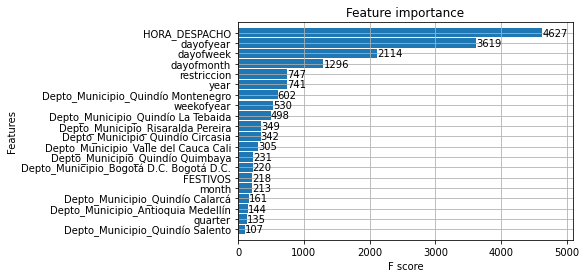

In [21]:
# Evaluate the model

xgb.plot_importance(model_armenia, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_armenia = model_armenia.predict(x_train_armenia)
print('R2 train',r2_score(y_train_armenia,predtrain_armenia))
print('MSE train',mean_squared_error(y_train_armenia,predtrain_armenia))
print('RMSE train',np.sqrt(mean_squared_error(y_train_armenia,predtrain_armenia)))

predtest_armenia=model_armenia.predict(x_test_armenia)
print('R2 test',r2_score(y_test_armenia,predtest_armenia))
print('MSE test',mean_squared_error(y_test_armenia,predtest_armenia))
print('RMSE test',np.sqrt(mean_squared_error(y_test_armenia,predtest_armenia)))

print('Percentil 99 Passengers',np.percentile(data_armenia['PASAJEROS'],99))


In [22]:
# Export model for dash / plotly
file_name = "xgb_model_armenia.pkl"

# save
pickle.dump(model_armenia, open(file_name, "wb"))

# T.T. DE BARRANQUILLA

In [23]:
# 1. Data wrangling

# a. Select the terminal

t_barranquilla=df[df['TERMINAL'] =='T.T. DE BARRANQUILLA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_barranquilla=t_barranquilla.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_barranquilla = data_barranquilla.rename(columns={'sum':'PASAJEROS'})

#Create new features

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_barranquilla['FESTIVOS'] = data_barranquilla['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

data_barranquilla['dayofweek'] = data_barranquilla['FECHA_DESPACHO'].dt.dayofweek
data_barranquilla['quarter'] = data_barranquilla['FECHA_DESPACHO'].dt.quarter
data_barranquilla['month'] = data_barranquilla['FECHA_DESPACHO'].dt.month
data_barranquilla['year'] = data_barranquilla['FECHA_DESPACHO'].dt.year
data_barranquilla['dayofyear'] = data_barranquilla['FECHA_DESPACHO'].dt.dayofyear
data_barranquilla['dayofmonth'] = data_barranquilla['FECHA_DESPACHO'].dt.day
data_barranquilla['weekofyear'] = data_barranquilla['FECHA_DESPACHO'].dt.weekofyear

# se crea una nueva variable que da cuenta de restricciones a la movilidad, 3 corresponde al valor sin restricciones, 0 alta
# restricción de movilidad que es el de periodos iniciales a la pandemia y 1 y 2 periodos posteriores siendo 2 el periodo después
# del inicio de vacunación

data_barranquilla["restriccion"] = np.where(data_barranquilla['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_barranquilla['FECHA_DESPACHO'] > '2020-03-26')&(data_barranquilla['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_barranquilla['FECHA_DESPACHO'] >='2020-09-01')&(data_barranquilla['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_barranquilla['FECHA_DESPACHO'] >='2021-03-01')&(data_barranquilla['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Se unicia departamento y municipio de destino en una sola variable

data_barranquilla["Depto_Municipio"]=data_barranquilla['DEPARTAMENTO_DESTINO']+' '+data_barranquilla['MUNICIPIO_DESTINO']


<ipython-input-23-68a4909e5d24>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_barranquilla['weekofyear'] = data_barranquilla['FECHA_DESPACHO'].dt.weekofyear


In [24]:
# Ejecución del modelo

# Set x, y
x_barranquilla=data_barranquilla.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_barranquilla=data_barranquilla['PASAJEROS']

# Encoding categorical data
x_barranquilla_encoded=pd.get_dummies(x_barranquilla, columns=["Depto_Municipio"])

# Data training and data test
x_train_barranquilla, x_test_barranquilla, y_train_barranquilla, y_test_barranquilla = train_test_split(x_barranquilla_encoded,y_barranquilla,test_size=0.2,random_state=42)
print(x_train_barranquilla.shape)
print(x_test_barranquilla.shape)

# define model
model_barranquilla = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_barranquilla.fit(x_train_barranquilla, y_train_barranquilla)


(92063, 38)
(23016, 38)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.6694668179423882
MSE train 113.39939068945907
RMSE train 10.648915000574428
R2 test 0.531632190059147
MSE test 160.45752381292354
RMSE test 12.667182947006156
Percentil 99 Passengers 86.0


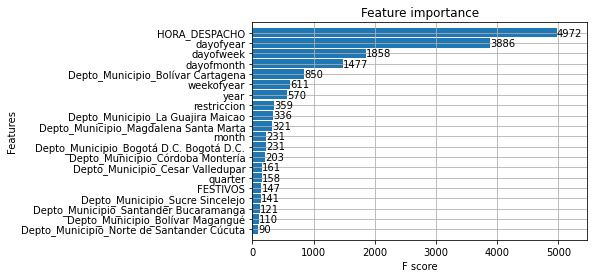

In [25]:
# Evaluate the model

xgb.plot_importance(model_barranquilla, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_barranquilla = model_barranquilla.predict(x_train_barranquilla)
print('R2 train',r2_score(y_train_barranquilla,predtrain_barranquilla))
print('MSE train',mean_squared_error(y_train_barranquilla,predtrain_barranquilla))
print('RMSE train',np.sqrt(mean_squared_error(y_train_barranquilla,predtrain_barranquilla)))

predtest_barranquilla=model_barranquilla.predict(x_test_barranquilla)
print('R2 test',r2_score(y_test_barranquilla,predtest_barranquilla))
print('MSE test',mean_squared_error(y_test_barranquilla,predtest_barranquilla))
print('RMSE test',np.sqrt(mean_squared_error(y_test_barranquilla,predtest_barranquilla)))

print('Percentil 99 Passengers',np.percentile(data_barranquilla['PASAJEROS'],99))


In [26]:
# Export model for dash / plotly
file_name = "xgb_model_barranquilla.pkl"

# save
pickle.dump(model_barranquilla, open(file_name, "wb"))

# T.T. BOGOTA NORTE

In [27]:
# 1. Data wrangling

# a. Select the terminal

t_bogota_norte=df[df['TERMINAL'] =='T.T. DE BOGOTÁ NORTE']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_bogota_norte=t_bogota_norte.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_bogota_norte = data_bogota_norte.rename(columns={'sum':'PASAJEROS'})

#Create new features

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_bogota_norte['FESTIVOS'] = data_bogota_norte['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

data_bogota_norte['dayofweek'] = data_bogota_norte['FECHA_DESPACHO'].dt.dayofweek
data_bogota_norte['quarter'] = data_bogota_norte['FECHA_DESPACHO'].dt.quarter
data_bogota_norte['month'] = data_bogota_norte['FECHA_DESPACHO'].dt.month
data_bogota_norte['year'] = data_bogota_norte['FECHA_DESPACHO'].dt.year
data_bogota_norte['dayofyear'] = data_bogota_norte['FECHA_DESPACHO'].dt.dayofyear
data_bogota_norte['dayofmonth'] = data_bogota_norte['FECHA_DESPACHO'].dt.day
data_bogota_norte['weekofyear'] = data_bogota_norte['FECHA_DESPACHO'].dt.weekofyear

# se crea una nueva variable que da cuenta de restricciones a la movilidad, 3 corresponde al valor sin restricciones, 0 alta
# restricción de movilidad que es el de periodos iniciales a la pandemia y 1 y 2 periodos posteriores siendo 2 el periodo después
# del inicio de vacunación

data_bogota_norte["restriccion"] = np.where(data_bogota_norte['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_bogota_norte['FECHA_DESPACHO'] > '2020-03-26')&(data_bogota_norte['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_bogota_norte['FECHA_DESPACHO'] >='2020-09-01')&(data_bogota_norte['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_bogota_norte['FECHA_DESPACHO'] >='2021-03-01')&(data_bogota_norte['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Se unicia departamento y municipio de destino en una sola variable

data_bogota_norte["Depto_Municipio"]=data_bogota_norte['DEPARTAMENTO_DESTINO']+' '+data_bogota_norte['MUNICIPIO_DESTINO']


<ipython-input-27-17cc5dc0713b>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_bogota_norte['weekofyear'] = data_bogota_norte['FECHA_DESPACHO'].dt.weekofyear


In [28]:
# Ejecución del modelo

# Set x, y
x_bogota_norte=data_bogota_norte.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_bogota_norte=data_bogota_norte['PASAJEROS']

# Encoding categorical data
x_bogota_norte_encoded=pd.get_dummies(x_bogota_norte, columns=["Depto_Municipio"])

# Data training and data test
x_train_bogota_norte, x_test_bogota_norte, y_train_bogota_norte, y_test_bogota_norte = train_test_split(x_bogota_norte_encoded,y_bogota_norte,test_size=0.2,random_state=42)
print(x_train_bogota_norte.shape)
print(x_test_bogota_norte.shape)

# define model
model_bogota_norte = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_bogota_norte.fit(x_train_bogota_norte, y_train_bogota_norte)


(191792, 141)
(47949, 141)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.8530608180368726
MSE train 39.7688499834199
RMSE train 6.306254830199926
R2 test 0.8061327141221126
MSE test 53.00854499950651
RMSE test 7.280696738603147
Percentil 99 Passengers 78.0


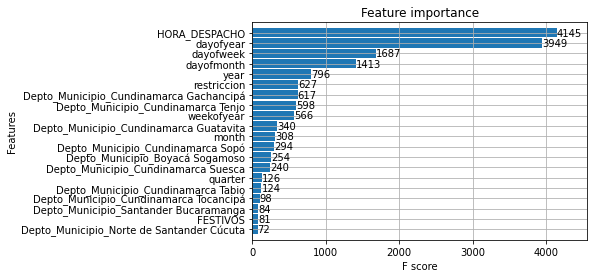

In [29]:
# Evaluate the model

xgb.plot_importance(model_bogota_norte, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_bogota_norte = model_bogota_norte.predict(x_train_bogota_norte)
print('R2 train',r2_score(y_train_bogota_norte,predtrain_bogota_norte))
print('MSE train',mean_squared_error(y_train_bogota_norte,predtrain_bogota_norte))
print('RMSE train',np.sqrt(mean_squared_error(y_train_bogota_norte,predtrain_bogota_norte)))

predtest_bogota_norte=model_bogota_norte.predict(x_test_bogota_norte)
print('R2 test',r2_score(y_test_bogota_norte,predtest_bogota_norte))
print('MSE test',mean_squared_error(y_test_bogota_norte,predtest_bogota_norte))
print('RMSE test',np.sqrt(mean_squared_error(y_test_bogota_norte,predtest_bogota_norte)))

print('Percentil 99 Passengers',np.percentile(data_bogota_norte['PASAJEROS'],99))


In [30]:
# Export model for dash / plotly
file_name = "xgb_model_bogota_norte.pkl"

# save
pickle.dump(model_bogota_norte, open(file_name, "wb"))

# T.T. BOGOTA SUR

In [31]:
# 1. Data wrangling

# a. Select the terminal

t_bogota_sur=df[df['TERMINAL'] =='T.T. DE BOGOTÁ SUR']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_bogota_sur=t_bogota_sur.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_bogota_sur = data_bogota_sur.rename(columns={'sum':'PASAJEROS'})

#Create new features

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_bogota_sur['FESTIVOS'] = data_bogota_sur['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

data_bogota_sur['dayofweek'] = data_bogota_sur['FECHA_DESPACHO'].dt.dayofweek
data_bogota_sur['quarter'] = data_bogota_sur['FECHA_DESPACHO'].dt.quarter
data_bogota_sur['month'] = data_bogota_sur['FECHA_DESPACHO'].dt.month
data_bogota_sur['year'] = data_bogota_sur['FECHA_DESPACHO'].dt.year
data_bogota_sur['dayofyear'] = data_bogota_sur['FECHA_DESPACHO'].dt.dayofyear
data_bogota_sur['dayofmonth'] = data_bogota_sur['FECHA_DESPACHO'].dt.day
data_bogota_sur['weekofyear'] = data_bogota_sur['FECHA_DESPACHO'].dt.weekofyear

# se crea una nueva variable que da cuenta de restricciones a la movilidad, 3 corresponde al valor sin restricciones, 0 alta
# restricción de movilidad que es el de periodos iniciales a la pandemia y 1 y 2 periodos posteriores siendo 2 el periodo después
# del inicio de vacunación

data_bogota_sur["restriccion"] = np.where(data_bogota_sur['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_bogota_sur['FECHA_DESPACHO'] > '2020-03-26')&(data_bogota_sur['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_bogota_sur['FECHA_DESPACHO'] >='2020-09-01')&(data_bogota_sur['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_bogota_sur['FECHA_DESPACHO'] >='2021-03-01')&(data_bogota_sur['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Se unicia departamento y municipio de destino en una sola variable

data_bogota_sur["Depto_Municipio"]=data_bogota_sur['DEPARTAMENTO_DESTINO']+' '+data_bogota_sur['MUNICIPIO_DESTINO']


<ipython-input-31-80b658aa9862>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_bogota_sur['weekofyear'] = data_bogota_sur['FECHA_DESPACHO'].dt.weekofyear


In [32]:
# Ejecución del modelo

# Set x, y
x_bogota_sur=data_bogota_sur.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_bogota_sur=data_bogota_sur['PASAJEROS']

# Encoding categorical data
x_bogota_sur_encoded=pd.get_dummies(x_bogota_sur, columns=["Depto_Municipio"])

# Data training and data test
x_train_bogota_sur, x_test_bogota_sur, y_train_bogota_sur, y_test_bogota_sur = train_test_split(x_bogota_sur_encoded,y_bogota_sur,test_size=0.2,random_state=42)
print(x_train_bogota_sur.shape)
print(x_test_bogota_sur.shape)

# define model
model_bogota_sur = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_bogota_sur.fit(x_train_bogota_sur, y_train_bogota_sur)


(132557, 84)
(33140, 84)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.8369463972014526
MSE train 122.64757502240377
RMSE train 11.074636563896973
R2 test 0.7713043431653429
MSE test 164.96295687774733
RMSE test 12.84379059614985
Percentil 99 Passengers 136.0


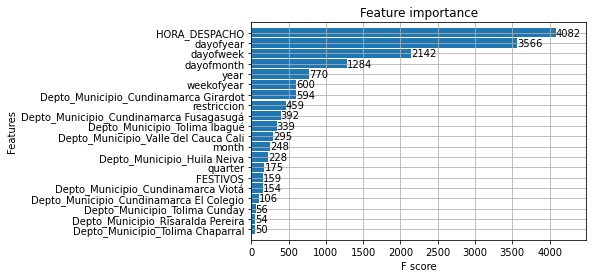

In [33]:
# Evaluate the model

xgb.plot_importance(model_bogota_sur, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_bogota_sur = model_bogota_sur.predict(x_train_bogota_sur)
print('R2 train',r2_score(y_train_bogota_sur,predtrain_bogota_sur))
print('MSE train',mean_squared_error(y_train_bogota_sur,predtrain_bogota_sur))
print('RMSE train',np.sqrt(mean_squared_error(y_train_bogota_sur,predtrain_bogota_sur)))

predtest_bogota_sur=model_bogota_sur.predict(x_test_bogota_sur)
print('R2 test',r2_score(y_test_bogota_sur,predtest_bogota_sur))
print('MSE test',mean_squared_error(y_test_bogota_sur,predtest_bogota_sur))
print('RMSE test',np.sqrt(mean_squared_error(y_test_bogota_sur,predtest_bogota_sur)))

print('Percentil 99 Passengers',np.percentile(data_bogota_sur['PASAJEROS'],99))

In [34]:
# Export model for dash / plotly
file_name = "xgb_model_bogota_sur.pkl"

# save
pickle.dump(model_bogota_sur, open(file_name, "wb"))

## T.T. DE BUGA

In [35]:
# 1. Data wrangling

# a. Select the terminal

t_buga=df[df['TERMINAL'] =='T.T. DE BUGA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_buga=t_buga.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_buga = data_buga.rename(columns={'sum':'PASAJEROS'})

#Create new features

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_buga['FESTIVOS'] = data_buga['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

data_buga['dayofweek'] = data_buga['FECHA_DESPACHO'].dt.dayofweek
data_buga['quarter'] = data_buga['FECHA_DESPACHO'].dt.quarter
data_buga['month'] = data_buga['FECHA_DESPACHO'].dt.month
data_buga['year'] = data_buga['FECHA_DESPACHO'].dt.year
data_buga['dayofyear'] = data_buga['FECHA_DESPACHO'].dt.dayofyear
data_buga['dayofmonth'] = data_buga['FECHA_DESPACHO'].dt.day
data_buga['weekofyear'] = data_buga['FECHA_DESPACHO'].dt.weekofyear

# se crea una nueva variable que da cuenta de restricciones a la movilidad, 3 corresponde al valor sin restricciones, 0 alta
# restricción de movilidad que es el de periodos iniciales a la pandemia y 1 y 2 periodos posteriores siendo 2 el periodo después
# del inicio de vacunación

data_buga["restriccion"] = np.where(data_buga['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_buga['FECHA_DESPACHO'] > '2020-03-26')&(data_buga['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_buga['FECHA_DESPACHO'] >='2020-09-01')&(data_buga['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_buga['FECHA_DESPACHO'] >='2021-03-01')&(data_buga['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Se unicia departamento y municipio de destino en una sola variable

data_buga["Depto_Municipio"]=data_buga['DEPARTAMENTO_DESTINO']+' '+data_buga['MUNICIPIO_DESTINO']


<ipython-input-35-2f2f6029b134>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_buga['weekofyear'] = data_buga['FECHA_DESPACHO'].dt.weekofyear


In [36]:
# Ejecución del modelo

# Set x, y
x_buga=data_buga.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_buga=data_buga['PASAJEROS']

# Encoding categorical data
x_buga_encoded=pd.get_dummies(x_buga, columns=["Depto_Municipio"])

# Data training and data test
x_train_buga, x_test_buga, y_train_buga, y_test_buga = train_test_split(x_buga_encoded,y_buga,test_size=0.2,random_state=42)
print(x_train_buga.shape)
print(x_test_buga.shape)

# define model
model_buga = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_buga.fit(x_train_buga, y_train_buga)


(88666, 37)
(22167, 37)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.9408368155485539
MSE train 75.93353337813706
RMSE train 8.71398493102536
R2 test 0.9133975725443017
MSE test 107.41894624130823
RMSE test 10.36431118026221
Percentil 99 Passengers 183.0


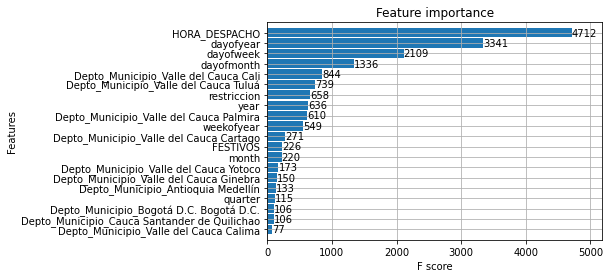

In [37]:
# Evaluate the model

xgb.plot_importance(model_buga, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_buga = model_buga.predict(x_train_buga)
print('R2 train',r2_score(y_train_buga,predtrain_buga))
print('MSE train',mean_squared_error(y_train_buga,predtrain_buga))
print('RMSE train',np.sqrt(mean_squared_error(y_train_buga,predtrain_buga)))

predtest_buga=model_buga.predict(x_test_buga)
print('R2 test',r2_score(y_test_buga,predtest_buga))
print('MSE test',mean_squared_error(y_test_buga,predtest_buga))
print('RMSE test',np.sqrt(mean_squared_error(y_test_buga,predtest_buga)))

print('Percentil 99 Passengers',np.percentile(data_buga['PASAJEROS'],99))


In [38]:
# Export model for dash / plotly
file_name = "xgb_model_buga.pkl"

# save
pickle.dump(model_buga, open(file_name, "wb"))

## T.T. DE CALI

In [39]:
# 1. Data wrangling

# a. Select the terminal

t_cali=df[df['TERMINAL'] =='T.T. DE CALI']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_cali=t_cali.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_cali = data_cali.rename(columns={'sum':'PASAJEROS'})

#Create new features

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_cali['FESTIVOS'] = data_cali['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

data_cali['dayofweek'] = data_cali['FECHA_DESPACHO'].dt.dayofweek
data_cali['quarter'] = data_cali['FECHA_DESPACHO'].dt.quarter
data_cali['month'] = data_cali['FECHA_DESPACHO'].dt.month
data_cali['year'] = data_cali['FECHA_DESPACHO'].dt.year
data_cali['dayofyear'] = data_cali['FECHA_DESPACHO'].dt.dayofyear
data_cali['dayofmonth'] = data_cali['FECHA_DESPACHO'].dt.day
data_cali['weekofyear'] = data_cali['FECHA_DESPACHO'].dt.weekofyear

# se crea una nueva variable que da cuenta de restricciones a la movilidad, 3 corresponde al valor sin restricciones, 0 alta
# restricción de movilidad que es el de periodos iniciales a la pandemia y 1 y 2 periodos posteriores siendo 2 el periodo después
# del inicio de vacunación

data_cali["restriccion"] = np.where(data_cali['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_cali['FECHA_DESPACHO'] > '2020-03-26')&(data_cali['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_cali['FECHA_DESPACHO'] >='2020-09-01')&(data_cali['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_cali['FECHA_DESPACHO'] >='2021-03-01')&(data_cali['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Se unicia departamento y municipio de destino en una sola variable

data_cali["Depto_Municipio"]=data_cali['DEPARTAMENTO_DESTINO']+' '+data_cali['MUNICIPIO_DESTINO']



<ipython-input-39-c191178483e4>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_cali['weekofyear'] = data_cali['FECHA_DESPACHO'].dt.weekofyear


In [40]:
# Ejecución del modelo

# Set x, y
x_cali=data_cali.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_cali=data_cali['PASAJEROS']

# Encoding categorical data
x_cali_encoded=pd.get_dummies(x_cali, columns=["Depto_Municipio"])

# Data training and data test
x_train_cali, x_test_cali, y_train_cali, y_test_cali = train_test_split(x_cali_encoded,y_cali,test_size=0.2,random_state=42)
print(x_train_cali.shape)
print(x_test_cali.shape)

# define model
model_cali = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_cali.fit(x_train_cali, y_train_cali)


(277713, 91)
(69429, 91)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.8611975857642276
MSE train 343.3657099641637
RMSE train 18.53012978810898
R2 test 0.83169385368022
MSE test 412.1187982427738
RMSE test 20.300709303932553
Percentil 99 Passengers 247.0


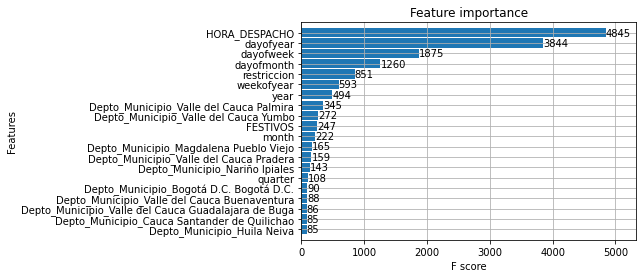

In [41]:
# Evaluate the model

xgb.plot_importance(model_cali, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_cali = model_cali.predict(x_train_cali)
print('R2 train',r2_score(y_train_cali,predtrain_cali))
print('MSE train',mean_squared_error(y_train_cali,predtrain_cali))
print('RMSE train',np.sqrt(mean_squared_error(y_train_cali,predtrain_cali)))

predtest_cali=model_cali.predict(x_test_cali)
print('R2 test',r2_score(y_test_cali,predtest_cali))
print('MSE test',mean_squared_error(y_test_cali,predtest_cali))
print('RMSE test',np.sqrt(mean_squared_error(y_test_cali,predtest_cali)))

print('Percentil 99 Passengers',np.percentile(data_cali['PASAJEROS'],99))

In [42]:
# Export model for dash / plotly
file_name = "xgb_model_cali.pkl"

# save
pickle.dump(model_cali, open(file_name, "wb"))

## T.T. DE CARTAGENA

In [43]:
# 1. Data wrangling

# a. Select the terminal

t_cartagena=df[df['TERMINAL'] =='T.T. DE CARTAGENA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_cartagena=t_cartagena.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_cartagena = data_cartagena.rename(columns={'sum':'PASAJEROS'})

#Create new features

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_cartagena['FESTIVOS'] = data_cartagena['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

data_cartagena['dayofweek'] = data_cartagena['FECHA_DESPACHO'].dt.dayofweek
data_cartagena['quarter'] = data_cartagena['FECHA_DESPACHO'].dt.quarter
data_cartagena['month'] = data_cartagena['FECHA_DESPACHO'].dt.month
data_cartagena['year'] = data_cartagena['FECHA_DESPACHO'].dt.year
data_cartagena['dayofyear'] = data_cartagena['FECHA_DESPACHO'].dt.dayofyear
data_cartagena['dayofmonth'] = data_cartagena['FECHA_DESPACHO'].dt.day
data_cartagena['weekofyear'] = data_cartagena['FECHA_DESPACHO'].dt.weekofyear

# se crea una nueva variable que da cuenta de restricciones a la movilidad, 3 corresponde al valor sin restricciones, 0 alta
# restricción de movilidad que es el de periodos iniciales a la pandemia y 1 y 2 periodos posteriores siendo 2 el periodo después
# del inicio de vacunación

data_cartagena["restriccion"] = np.where(data_cartagena['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_cartagena['FECHA_DESPACHO'] > '2020-03-26')&(data_cartagena['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_cartagena['FECHA_DESPACHO'] >='2020-09-01')&(data_cartagena['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_cartagena['FECHA_DESPACHO'] >='2021-03-01')&(data_cartagena['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Se unicia departamento y municipio de destino en una sola variable

data_cartagena["Depto_Municipio"]=data_cartagena['DEPARTAMENTO_DESTINO']+' '+data_cartagena['MUNICIPIO_DESTINO']


<ipython-input-43-328081ca0fba>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_cartagena['weekofyear'] = data_cartagena['FECHA_DESPACHO'].dt.weekofyear


In [44]:
# Ejecución del modelo

# Set x, y
x_cartagena=data_cartagena.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_cartagena=data_cartagena['PASAJEROS']

# Encoding categorical data
x_cartagena_encoded=pd.get_dummies(x_cartagena, columns=["Depto_Municipio"])

# Data training and data test
x_train_cartagena, x_test_cartagena, y_train_cartagena, y_test_cartagena = train_test_split(x_cartagena_encoded,y_cartagena,test_size=0.2,random_state=42)
print(x_train_cartagena.shape)
print(x_test_cartagena.shape)

# define model
model_cartagena = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_cartagena.fit(x_train_cartagena, y_train_cartagena)


(119259, 48)
(29815, 48)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.7863218903114577
MSE train 272.48523145570505
RMSE train 16.507126686849684
R2 test 0.7146615762372713
MSE test 358.0081416175005
RMSE test 18.921103076129057
Percentil 99 Passengers 179.0


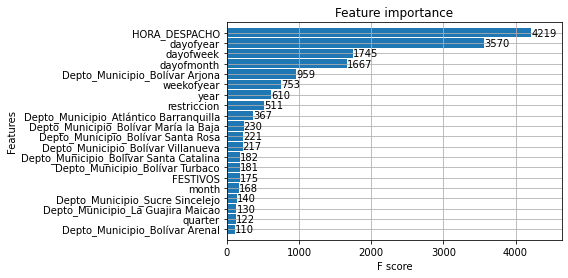

In [45]:
# Evaluate the model

xgb.plot_importance(model_cartagena, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_cartagena = model_cartagena.predict(x_train_cartagena)
print('R2 train',r2_score(y_train_cartagena,predtrain_cartagena))
print('MSE train',mean_squared_error(y_train_cartagena,predtrain_cartagena))
print('RMSE train',np.sqrt(mean_squared_error(y_train_cartagena,predtrain_cartagena)))

predtest_cartagena=model_cartagena.predict(x_test_cartagena)
print('R2 test',r2_score(y_test_cartagena,predtest_cartagena))
print('MSE test',mean_squared_error(y_test_cartagena,predtest_cartagena))
print('RMSE test',np.sqrt(mean_squared_error(y_test_cartagena,predtest_cartagena)))

print('Percentil 99 Passengers',np.percentile(data_cartagena['PASAJEROS'],99))


In [46]:
# Export model for dash / plotly
file_name = "xgb_model_cartagena.pkl"

# save
pickle.dump(model_cartagena, open(file_name, "wb"))

## T.T. DE CHIQUINQUIRÁ

In [47]:
# 1. Data wrangling

# a. Select the terminal

t_chiquinquira=df[df['TERMINAL'] =='T.T. DE CHIQUINQUIRÁ']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_chiquinquira=t_chiquinquira.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_chiquinquira = data_chiquinquira.rename(columns={'sum':'PASAJEROS'})

#Create new features

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_chiquinquira['FESTIVOS'] = data_chiquinquira['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

data_chiquinquira['dayofweek'] = data_chiquinquira['FECHA_DESPACHO'].dt.dayofweek
data_chiquinquira['quarter'] = data_chiquinquira['FECHA_DESPACHO'].dt.quarter
data_chiquinquira['month'] = data_chiquinquira['FECHA_DESPACHO'].dt.month
data_chiquinquira['year'] = data_chiquinquira['FECHA_DESPACHO'].dt.year
data_chiquinquira['dayofyear'] = data_chiquinquira['FECHA_DESPACHO'].dt.dayofyear
data_chiquinquira['dayofmonth'] = data_chiquinquira['FECHA_DESPACHO'].dt.day
data_chiquinquira['weekofyear'] = data_chiquinquira['FECHA_DESPACHO'].dt.weekofyear

# se crea una nueva variable que da cuenta de restricciones a la movilidad, 3 corresponde al valor sin restricciones, 0 alta
# restricción de movilidad que es el de periodos iniciales a la pandemia y 1 y 2 periodos posteriores siendo 2 el periodo después
# del inicio de vacunación

data_chiquinquira["restriccion"] = np.where(data_chiquinquira['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_chiquinquira['FECHA_DESPACHO'] > '2020-03-26')&(data_chiquinquira['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_chiquinquira['FECHA_DESPACHO'] >='2020-09-01')&(data_chiquinquira['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_chiquinquira['FECHA_DESPACHO'] >='2021-03-01')&(data_chiquinquira['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Se unicia departamento y municipio de destino en una sola variable

data_chiquinquira["Depto_Municipio"]=data_chiquinquira['DEPARTAMENTO_DESTINO']+' '+data_chiquinquira['MUNICIPIO_DESTINO']


<ipython-input-47-20407f735bc9>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_chiquinquira['weekofyear'] = data_chiquinquira['FECHA_DESPACHO'].dt.weekofyear


In [48]:
# Ejecución del modelo

# Set x, y
x_chiquinquira=data_chiquinquira.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_chiquinquira=data_chiquinquira['PASAJEROS']

# Encoding categorical data
x_chiquinquira_encoded=pd.get_dummies(x_chiquinquira, columns=["Depto_Municipio"])

# Data training and data test
x_train_chiquinquira, x_test_chiquinquira, y_train_chiquinquira, y_test_chiquinquira = train_test_split(x_chiquinquira_encoded,y_chiquinquira,test_size=0.2,random_state=42)
print(x_train_chiquinquira.shape)
print(x_test_chiquinquira.shape)

# define model
model_chiquinquira = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_chiquinquira.fit(x_train_chiquinquira, y_train_chiquinquira)


(68594, 40)
(17149, 40)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.9286841744820505
MSE train 61.19430263965448
RMSE train 7.82267873810848
R2 test 0.8673839393231842
MSE test 120.84201481376391
RMSE test 10.992816509601345
Percentil 99 Passengers 138.0


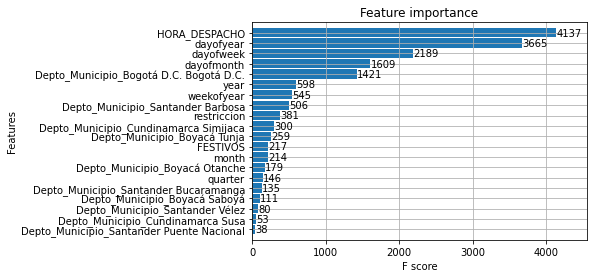

In [49]:
# Evaluate the model

xgb.plot_importance(model_chiquinquira, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_chiquinquira = model_chiquinquira.predict(x_train_chiquinquira)
print('R2 train',r2_score(y_train_chiquinquira,predtrain_chiquinquira))
print('MSE train',mean_squared_error(y_train_chiquinquira,predtrain_chiquinquira))
print('RMSE train',np.sqrt(mean_squared_error(y_train_chiquinquira,predtrain_chiquinquira)))

predtest_chiquinquira=model_chiquinquira.predict(x_test_chiquinquira)
print('R2 test',r2_score(y_test_chiquinquira,predtest_chiquinquira))
print('MSE test',mean_squared_error(y_test_chiquinquira,predtest_chiquinquira))
print('RMSE test',np.sqrt(mean_squared_error(y_test_chiquinquira,predtest_chiquinquira)))

print('Percentil 99 Passengers',np.percentile(data_chiquinquira['PASAJEROS'],99))

In [50]:
# Export model for dash / plotly
file_name = "xgb_model_chiquinquira.pkl"

# save
pickle.dump(model_chiquinquira, open(file_name, "wb"))

## T.T. DE CÚCUTA

In [51]:
# 1. Data wrangling

# a. Select the terminal

t_cucuta=df[df['TERMINAL'] =='T.T. DE CÚCUTA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_cucuta=t_cucuta.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_cucuta = data_cucuta.rename(columns={'sum':'PASAJEROS'})

#Create new features

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_cucuta['FESTIVOS'] = data_cucuta['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

data_cucuta['dayofweek'] = data_cucuta['FECHA_DESPACHO'].dt.dayofweek
data_cucuta['quarter'] = data_cucuta['FECHA_DESPACHO'].dt.quarter
data_cucuta['month'] = data_cucuta['FECHA_DESPACHO'].dt.month
data_cucuta['year'] = data_cucuta['FECHA_DESPACHO'].dt.year
data_cucuta['dayofyear'] = data_cucuta['FECHA_DESPACHO'].dt.dayofyear
data_cucuta['dayofmonth'] = data_cucuta['FECHA_DESPACHO'].dt.day
data_cucuta['weekofyear'] = data_cucuta['FECHA_DESPACHO'].dt.weekofyear

# se crea una nueva variable que da cuenta de restricciones a la movilidad, 3 corresponde al valor sin restricciones, 0 alta
# restricción de movilidad que es el de periodos iniciales a la pandemia y 1 y 2 periodos posteriores siendo 2 el periodo después
# del inicio de vacunación

data_cucuta["restriccion"] = np.where(data_cucuta['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_cucuta['FECHA_DESPACHO'] > '2020-03-26')&(data_cucuta['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_cucuta['FECHA_DESPACHO'] >='2020-09-01')&(data_cucuta['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_cucuta['FECHA_DESPACHO'] >='2021-03-01')&(data_cucuta['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Se unicia departamento y municipio de destino en una sola variable

data_cucuta["Depto_Municipio"]=data_cucuta['DEPARTAMENTO_DESTINO']+' '+data_cucuta['MUNICIPIO_DESTINO']


<ipython-input-51-23ac761ab3ed>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_cucuta['weekofyear'] = data_cucuta['FECHA_DESPACHO'].dt.weekofyear


In [52]:
# Ejecución del modelo

# Set x, y
x_cucuta=data_cucuta.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_cucuta=data_cucuta['PASAJEROS']

# Encoding categorical data
x_cucuta_encoded=pd.get_dummies(x_cucuta, columns=["Depto_Municipio"])

# Data training and data test
x_train_cucuta, x_test_cucuta, y_train_cucuta, y_test_cucuta = train_test_split(x_cucuta_encoded,y_cucuta,test_size=0.2,random_state=42)
print(x_train_cucuta.shape)
print(x_test_cucuta.shape)

# define model
model_cucuta = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_cucuta.fit(x_train_cucuta, y_train_cucuta)


(74483, 53)
(18621, 53)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.7948315702676021
MSE train 110.35375422233295
RMSE train 10.504939515405738
R2 test 0.658801170482477
MSE test 181.4489912717627
RMSE test 13.470300340815074
Percentil 99 Passengers 124.0


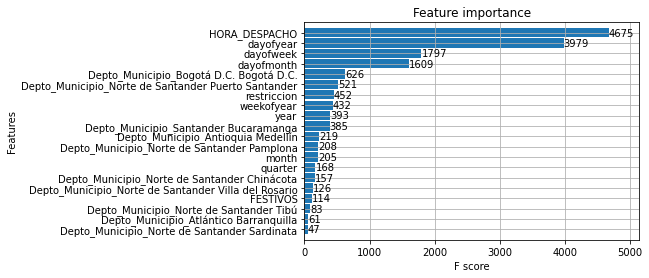

In [53]:
# Evaluate the model

xgb.plot_importance(model_cucuta, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_cucuta = model_cucuta.predict(x_train_cucuta)
print('R2 train',r2_score(y_train_cucuta,predtrain_cucuta))
print('MSE train',mean_squared_error(y_train_cucuta,predtrain_cucuta))
print('RMSE train',np.sqrt(mean_squared_error(y_train_cucuta,predtrain_cucuta)))

predtest_cucuta=model_cucuta.predict(x_test_cucuta)
print('R2 test',r2_score(y_test_cucuta,predtest_cucuta))
print('MSE test',mean_squared_error(y_test_cucuta,predtest_cucuta))
print('RMSE test',np.sqrt(mean_squared_error(y_test_cucuta,predtest_cucuta)))

print('Percentil 99 Passengers',np.percentile(data_cucuta['PASAJEROS'],99))

In [54]:
# Export model for dash / plotly
file_name = "xgb_model_cucuta.pkl"

# save
pickle.dump(model_cucuta, open(file_name, "wb"))

## T.T. DE DUITAMA

In [55]:
# 1. Data wrangling

# a. Select the terminal

t_duitama=df[df['TERMINAL'] =='T.T. DE DUITAMA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_duitama=t_duitama.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_duitama = data_duitama.rename(columns={'sum':'PASAJEROS'})

#Create new features

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_duitama['FESTIVOS'] = data_duitama['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

data_duitama['dayofweek'] = data_duitama['FECHA_DESPACHO'].dt.dayofweek
data_duitama['quarter'] = data_duitama['FECHA_DESPACHO'].dt.quarter
data_duitama['month'] = data_duitama['FECHA_DESPACHO'].dt.month
data_duitama['year'] = data_duitama['FECHA_DESPACHO'].dt.year
data_duitama['dayofyear'] = data_duitama['FECHA_DESPACHO'].dt.dayofyear
data_duitama['dayofmonth'] = data_duitama['FECHA_DESPACHO'].dt.day
data_duitama['weekofyear'] = data_duitama['FECHA_DESPACHO'].dt.weekofyear

# se crea una nueva variable que da cuenta de restricciones a la movilidad, 3 corresponde al valor sin restricciones, 0 alta
# restricción de movilidad que es el de periodos iniciales a la pandemia y 1 y 2 periodos posteriores siendo 2 el periodo después
# del inicio de vacunación

data_duitama["restriccion"] = np.where(data_duitama['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_duitama['FECHA_DESPACHO'] > '2020-03-26')&(data_duitama['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_duitama['FECHA_DESPACHO'] >='2020-09-01')&(data_duitama['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_duitama['FECHA_DESPACHO'] >='2021-03-01')&(data_duitama['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Se unicia departamento y municipio de destino en una sola variable

data_duitama["Depto_Municipio"]=data_duitama['DEPARTAMENTO_DESTINO']+' '+data_duitama['MUNICIPIO_DESTINO']


<ipython-input-55-873106494bbe>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_duitama['weekofyear'] = data_duitama['FECHA_DESPACHO'].dt.weekofyear


In [56]:
# Ejecución del modelo

# Set x, y
x_duitama=data_duitama.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_duitama=data_duitama['PASAJEROS']

# Encoding categorical data
x_duitama_encoded=pd.get_dummies(x_duitama, columns=["Depto_Municipio"])

# Data training and data test
x_train_duitama, x_test_duitama, y_train_duitama, y_test_duitama = train_test_split(x_duitama_encoded,y_duitama,test_size=0.2,random_state=42)
print(x_train_duitama.shape)
print(x_test_duitama.shape)

# define model
model_duitama = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_duitama.fit(x_train_duitama, y_train_duitama)


(90053, 53)
(22514, 53)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.9012071867760747
MSE train 212.43524384508387
RMSE train 14.57515845008499
R2 test 0.8704683118789067
MSE test 287.9731464221209
RMSE test 16.969771548907808
Percentil 99 Passengers 223.0


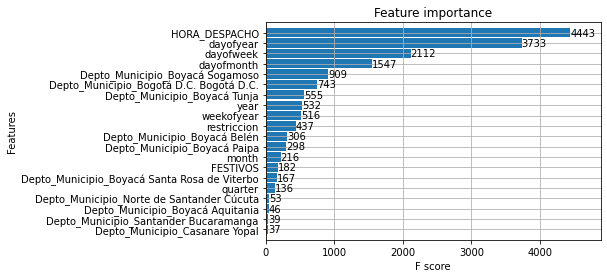

In [57]:
# Evaluate the model

xgb.plot_importance(model_duitama, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_duitama = model_duitama.predict(x_train_duitama)
print('R2 train',r2_score(y_train_duitama,predtrain_duitama))
print('MSE train',mean_squared_error(y_train_duitama,predtrain_duitama))
print('RMSE train',np.sqrt(mean_squared_error(y_train_duitama,predtrain_duitama)))

predtest_duitama=model_duitama.predict(x_test_duitama)
print('R2 test',r2_score(y_test_duitama,predtest_duitama))
print('MSE test',mean_squared_error(y_test_duitama,predtest_duitama))
print('RMSE test',np.sqrt(mean_squared_error(y_test_duitama,predtest_duitama)))

print('Percentil 99 Passengers',np.percentile(data_duitama['PASAJEROS'],99))


In [58]:
# Export model for dash / plotly
file_name = "xgb_model_duitama.pkl"

# save
pickle.dump(model_duitama, open(file_name, "wb"))

## T.T. DE ESPINAL

In [59]:
# 1. Data wrangling

# a. Select the terminal

t_espinal=df[df['TERMINAL'] =='T.T. DE ESPINAL']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_espinal=t_espinal.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_espinal = data_espinal.rename(columns={'sum':'PASAJEROS'})

#Create new features

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_espinal['FESTIVOS'] = data_espinal['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

data_espinal['dayofweek'] = data_espinal['FECHA_DESPACHO'].dt.dayofweek
data_espinal['quarter'] = data_espinal['FECHA_DESPACHO'].dt.quarter
data_espinal['month'] = data_espinal['FECHA_DESPACHO'].dt.month
data_espinal['year'] = data_espinal['FECHA_DESPACHO'].dt.year
data_espinal['dayofyear'] = data_espinal['FECHA_DESPACHO'].dt.dayofyear
data_espinal['dayofmonth'] = data_espinal['FECHA_DESPACHO'].dt.day
data_espinal['weekofyear'] = data_espinal['FECHA_DESPACHO'].dt.weekofyear

# se crea una nueva variable que da cuenta de restricciones a la movilidad, 3 corresponde al valor sin restricciones, 0 alta
# restricción de movilidad que es el de periodos iniciales a la pandemia y 1 y 2 periodos posteriores siendo 2 el periodo después
# del inicio de vacunación

data_espinal["restriccion"] = np.where(data_espinal['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_espinal['FECHA_DESPACHO'] > '2020-03-26')&(data_espinal['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_espinal['FECHA_DESPACHO'] >='2020-09-01')&(data_espinal['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_espinal['FECHA_DESPACHO'] >='2021-03-01')&(data_espinal['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Se unicia departamento y municipio de destino en una sola variable

data_espinal["Depto_Municipio"]=data_espinal['DEPARTAMENTO_DESTINO']+' '+data_espinal['MUNICIPIO_DESTINO']


<ipython-input-59-7cc2b2c38759>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_espinal['weekofyear'] = data_espinal['FECHA_DESPACHO'].dt.weekofyear


In [60]:
# Ejecución del modelo

# Set x, y
x_espinal=data_espinal.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_espinal=data_espinal['PASAJEROS']

# Encoding categorical data
x_espinal_encoded=pd.get_dummies(x_espinal, columns=["Depto_Municipio"])

# Data training and data test
x_train_espinal, x_test_espinal, y_train_espinal, y_test_espinal = train_test_split(x_espinal_encoded,y_espinal,test_size=0.2,random_state=42)
print(x_train_espinal.shape)
print(x_test_espinal.shape)

# define model
model_espinal = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_espinal.fit(x_train_espinal, y_train_espinal)


(77490, 44)
(19373, 44)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.8630897470573572
MSE train 90.68215980255827
RMSE train 9.522718088999499
R2 test 0.783311946259748
MSE test 152.78528760883927
RMSE test 12.360634595717134
Percentil 99 Passengers 114.0


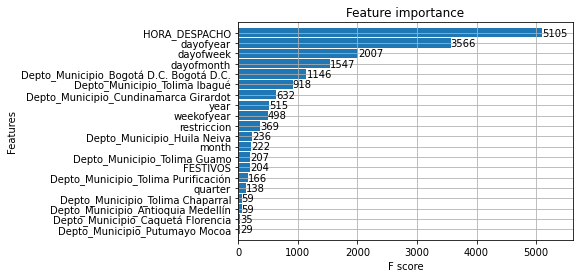

In [61]:
# Evaluate the model

xgb.plot_importance(model_espinal, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_espinal = model_espinal.predict(x_train_espinal)
print('R2 train',r2_score(y_train_espinal,predtrain_espinal))
print('MSE train',mean_squared_error(y_train_espinal,predtrain_espinal))
print('RMSE train',np.sqrt(mean_squared_error(y_train_espinal,predtrain_espinal)))

predtest_espinal=model_espinal.predict(x_test_espinal)
print('R2 test',r2_score(y_test_espinal,predtest_espinal))
print('MSE test',mean_squared_error(y_test_espinal,predtest_espinal))
print('RMSE test',np.sqrt(mean_squared_error(y_test_espinal,predtest_espinal)))

print('Percentil 99 Passengers',np.percentile(data_espinal['PASAJEROS'],99))


In [62]:
# Export model for dash / plotly
file_name = "xgb_model_espinal.pkl"

# save
pickle.dump(model_espinal, open(file_name, "wb"))

## T.T. DE FLORENCIA

In [63]:
# 1. Data wrangling

# a. Select the terminal

t_florencia=df[df['TERMINAL'] =='T.T. DE FLORENCIA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_florencia=t_florencia.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_florencia = data_florencia.rename(columns={'sum':'PASAJEROS'})

#Create new features

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_florencia['FESTIVOS'] = data_florencia['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

data_florencia['dayofweek'] = data_florencia['FECHA_DESPACHO'].dt.dayofweek
data_florencia['quarter'] = data_florencia['FECHA_DESPACHO'].dt.quarter
data_florencia['month'] = data_florencia['FECHA_DESPACHO'].dt.month
data_florencia['year'] = data_florencia['FECHA_DESPACHO'].dt.year
data_florencia['dayofyear'] = data_florencia['FECHA_DESPACHO'].dt.dayofyear
data_florencia['dayofmonth'] = data_florencia['FECHA_DESPACHO'].dt.day
data_florencia['weekofyear'] = data_florencia['FECHA_DESPACHO'].dt.weekofyear

# se crea una nueva variable que da cuenta de restricciones a la movilidad, 3 corresponde al valor sin restricciones, 0 alta
# restricción de movilidad que es el de periodos iniciales a la pandemia y 1 y 2 periodos posteriores siendo 2 el periodo después
# del inicio de vacunación

data_florencia["restriccion"] = np.where(data_florencia['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_florencia['FECHA_DESPACHO'] > '2020-03-26')&(data_florencia['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_florencia['FECHA_DESPACHO'] >='2020-09-01')&(data_florencia['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_florencia['FECHA_DESPACHO'] >='2021-03-01')&(data_florencia['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Se unicia departamento y municipio de destino en una sola variable

data_florencia["Depto_Municipio"]=data_florencia['DEPARTAMENTO_DESTINO']+' '+data_florencia['MUNICIPIO_DESTINO']


<ipython-input-63-0a87690b76b5>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_florencia['weekofyear'] = data_florencia['FECHA_DESPACHO'].dt.weekofyear


In [64]:
# Ejecución del modelo

# Set x, y
x_florencia=data_florencia.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_florencia=data_florencia['PASAJEROS']

# Encoding categorical data
x_florencia_encoded=pd.get_dummies(x_florencia, columns=["Depto_Municipio"])

# Data training and data test
x_train_florencia, x_test_florencia, y_train_florencia, y_test_florencia = train_test_split(x_florencia_encoded,y_florencia,test_size=0.2,random_state=42)
print(x_train_florencia.shape)
print(x_test_florencia.shape)

# define model
model_florencia = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_florencia.fit(x_train_florencia, y_train_florencia)


(87600, 38)
(21900, 38)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.7814483627863597
MSE train 27.10430480416035
RMSE train 5.206179482515019
R2 test 0.6839643716910967
MSE test 38.834786604973694
RMSE test 6.231756301795962
Percentil 99 Passengers 53.0


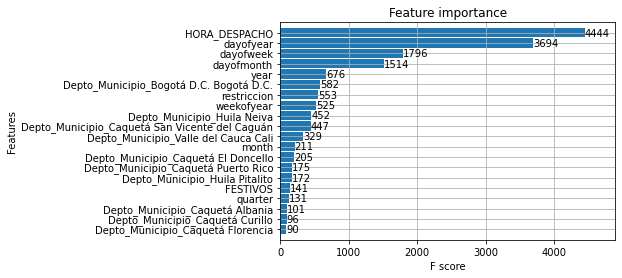

In [65]:
# Evaluate the model

xgb.plot_importance(model_florencia, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_florencia = model_florencia.predict(x_train_florencia)
print('R2 train',r2_score(y_train_florencia,predtrain_florencia))
print('MSE train',mean_squared_error(y_train_florencia,predtrain_florencia))
print('RMSE train',np.sqrt(mean_squared_error(y_train_florencia,predtrain_florencia)))

predtest_florencia=model_florencia.predict(x_test_florencia)
print('R2 test',r2_score(y_test_florencia,predtest_florencia))
print('MSE test',mean_squared_error(y_test_florencia,predtest_florencia))
print('RMSE test',np.sqrt(mean_squared_error(y_test_florencia,predtest_florencia)))

print('Percentil 99 Passengers',np.percentile(data_florencia['PASAJEROS'],99))

In [66]:
# Export model for dash / plotly
file_name = "xgb_model_florencia.pkl"

# save
pickle.dump(model_florencia, open(file_name, "wb"))

## T.T. DE FUSAGASUGA

In [67]:
# 1. Data wrangling

# a. Select the terminal

t_fusagasuga=df[df['TERMINAL'] =='T.T. DE FUSAGASUGA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_fusagasuga=t_fusagasuga.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_fusagasuga = data_fusagasuga.rename(columns={'sum':'PASAJEROS'})

#Create new features

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_fusagasuga['FESTIVOS'] = data_fusagasuga['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

data_fusagasuga['dayofweek'] = data_fusagasuga['FECHA_DESPACHO'].dt.dayofweek
data_fusagasuga['quarter'] = data_fusagasuga['FECHA_DESPACHO'].dt.quarter
data_fusagasuga['month'] = data_fusagasuga['FECHA_DESPACHO'].dt.month
data_fusagasuga['year'] = data_fusagasuga['FECHA_DESPACHO'].dt.year
data_fusagasuga['dayofyear'] = data_fusagasuga['FECHA_DESPACHO'].dt.dayofyear
data_fusagasuga['dayofmonth'] = data_fusagasuga['FECHA_DESPACHO'].dt.day
data_fusagasuga['weekofyear'] = data_fusagasuga['FECHA_DESPACHO'].dt.weekofyear

# se crea una nueva variable que da cuenta de restricciones a la movilidad, 3 corresponde al valor sin restricciones, 0 alta
# restricción de movilidad que es el de periodos iniciales a la pandemia y 1 y 2 periodos posteriores siendo 2 el periodo después
# del inicio de vacunación

data_fusagasuga["restriccion"] = np.where(data_fusagasuga['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_fusagasuga['FECHA_DESPACHO'] > '2020-03-26')&(data_fusagasuga['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_fusagasuga['FECHA_DESPACHO'] >='2020-09-01')&(data_fusagasuga['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_fusagasuga['FECHA_DESPACHO'] >='2021-03-01')&(data_fusagasuga['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Se unicia departamento y municipio de destino en una sola variable

data_fusagasuga["Depto_Municipio"]=data_fusagasuga['DEPARTAMENTO_DESTINO']+' '+data_fusagasuga['MUNICIPIO_DESTINO']


<ipython-input-67-2f3ca7d47739>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_fusagasuga['weekofyear'] = data_fusagasuga['FECHA_DESPACHO'].dt.weekofyear


In [68]:
# Ejecución del modelo

# Set x, y
x_fusagasuga=data_fusagasuga.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_fusagasuga=data_fusagasuga['PASAJEROS']

# Encoding categorical data
x_fusagasuga_encoded=pd.get_dummies(x_fusagasuga, columns=["Depto_Municipio"])

# Data training and data test
x_train_fusagasuga, x_test_fusagasuga, y_train_fusagasuga, y_test_fusagasuga = train_test_split(x_fusagasuga_encoded,y_fusagasuga,test_size=0.2,random_state=42)
print(x_train_fusagasuga.shape)
print(x_test_fusagasuga.shape)

# define model
model_fusagasuga = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_fusagasuga.fit(x_train_fusagasuga, y_train_fusagasuga)


(65332, 47)
(16334, 47)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.9488884125171974
MSE train 80.762535744086
RMSE train 8.986797858196544
R2 test 0.8827321442246256
MSE test 188.07385568819862
RMSE test 13.714002176177406
Percentil 99 Passengers 203.0


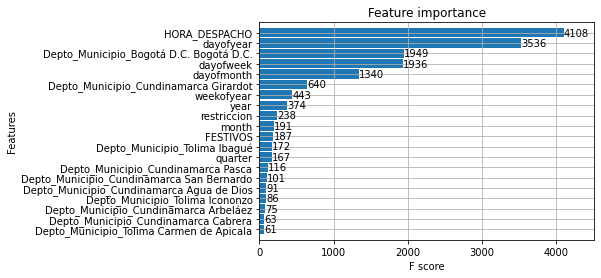

In [70]:
# Evaluate the model

xgb.plot_importance(model_fusagasuga, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_fusagasuga = model_fusagasuga.predict(x_train_fusagasuga)
print('R2 train',r2_score(y_train_fusagasuga,predtrain_fusagasuga))
print('MSE train',mean_squared_error(y_train_fusagasuga,predtrain_fusagasuga))
print('RMSE train',np.sqrt(mean_squared_error(y_train_fusagasuga,predtrain_fusagasuga)))

predtest_fusagasuga=model_fusagasuga.predict(x_test_fusagasuga)
print('R2 test',r2_score(y_test_fusagasuga,predtest_fusagasuga))
print('MSE test',mean_squared_error(y_test_fusagasuga,predtest_fusagasuga))
print('RMSE test',np.sqrt(mean_squared_error(y_test_fusagasuga,predtest_fusagasuga)))

print('Percentil 99 Passengers',np.percentile(data_fusagasuga['PASAJEROS'],99))

In [71]:
# Export model for dash / plotly
file_name = "xgb_model_fusagasuga.pkl"

# save
pickle.dump(model_fusagasuga, open(file_name, "wb"))

## T.T. DE GARZÓN

In [72]:
# 1. Data wrangling

# a. Select the terminal

t_garzon=df[df['TERMINAL'] =='T.T. DE GARZÓN']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_garzon=t_garzon.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_garzon = data_garzon.rename(columns={'sum':'PASAJEROS'})

#Create new features

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_garzon['FESTIVOS'] = data_garzon['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

data_garzon['dayofweek'] = data_garzon['FECHA_DESPACHO'].dt.dayofweek
data_garzon['quarter'] = data_garzon['FECHA_DESPACHO'].dt.quarter
data_garzon['month'] = data_garzon['FECHA_DESPACHO'].dt.month
data_garzon['year'] = data_garzon['FECHA_DESPACHO'].dt.year
data_garzon['dayofyear'] = data_garzon['FECHA_DESPACHO'].dt.dayofyear
data_garzon['dayofmonth'] = data_garzon['FECHA_DESPACHO'].dt.day
data_garzon['weekofyear'] = data_garzon['FECHA_DESPACHO'].dt.weekofyear

# se crea una nueva variable que da cuenta de restricciones a la movilidad, 3 corresponde al valor sin restricciones, 0 alta
# restricción de movilidad que es el de periodos iniciales a la pandemia y 1 y 2 periodos posteriores siendo 2 el periodo después
# del inicio de vacunación

data_garzon["restriccion"] = np.where(data_garzon['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_garzon['FECHA_DESPACHO'] > '2020-03-26')&(data_garzon['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_garzon['FECHA_DESPACHO'] >='2020-09-01')&(data_garzon['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_garzon['FECHA_DESPACHO'] >='2021-03-01')&(data_garzon['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Se unicia departamento y municipio de destino en una sola variable

data_garzon["Depto_Municipio"]=data_garzon['DEPARTAMENTO_DESTINO']+' '+data_garzon['MUNICIPIO_DESTINO']


<ipython-input-72-437c663d5d07>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_garzon['weekofyear'] = data_garzon['FECHA_DESPACHO'].dt.weekofyear


In [73]:
# Ejecución del modelo

# Set x, y
x_garzon=data_garzon.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_garzon=data_garzon['PASAJEROS']

# Encoding categorical data
x_garzon_encoded=pd.get_dummies(x_garzon, columns=["Depto_Municipio"])

# Data training and data test
x_train_garzon, x_test_garzon, y_train_garzon, y_test_garzon = train_test_split(x_garzon_encoded,y_garzon,test_size=0.2,random_state=42)
print(x_train_garzon.shape)
print(x_test_garzon.shape)

# define model
model_garzon = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_garzon.fit(x_train_garzon, y_train_garzon)


(76090, 57)
(19023, 57)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.80809840019801
MSE train 28.798726393664275
RMSE train 5.366444483423291
R2 test 0.7027380430690117
MSE test 44.06226525003915
RMSE test 6.637941341262301
Percentil 99 Passengers 57.0


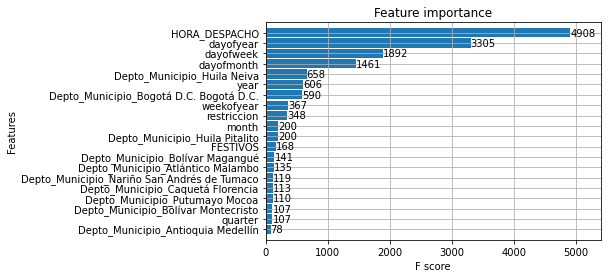

In [74]:
# Evaluate the model

xgb.plot_importance(model_garzon, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_garzon = model_garzon.predict(x_train_garzon)
print('R2 train',r2_score(y_train_garzon,predtrain_garzon))
print('MSE train',mean_squared_error(y_train_garzon,predtrain_garzon))
print('RMSE train',np.sqrt(mean_squared_error(y_train_garzon,predtrain_garzon)))

predtest_garzon=model_garzon.predict(x_test_garzon)
print('R2 test',r2_score(y_test_garzon,predtest_garzon))
print('MSE test',mean_squared_error(y_test_garzon,predtest_garzon))
print('RMSE test',np.sqrt(mean_squared_error(y_test_garzon,predtest_garzon)))

print('Percentil 99 Passengers',np.percentile(data_garzon['PASAJEROS'],99))

In [75]:
# Export model for dash / plotly
file_name = "xgb_model_garzon.pkl"

# save
pickle.dump(model_garzon, open(file_name, "wb"))

## T.T. DE GIRARDOT

In [3]:
# 1. Data wrangling

# a. Select the terminal
t_girardot=df[df['TERMINAL'] =='T.T. DE GIRARDOT']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_girardot=t_girardot.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_girardot = data_girardot.rename(columns={'sum':'PASAJEROS'})

#Create new features

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_girardot['FESTIVOS'] = data_girardot['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

data_girardot['dayofweek'] = data_girardot['FECHA_DESPACHO'].dt.dayofweek
data_girardot['quarter'] = data_girardot['FECHA_DESPACHO'].dt.quarter
data_girardot['month'] = data_girardot['FECHA_DESPACHO'].dt.month
data_girardot['year'] = data_girardot['FECHA_DESPACHO'].dt.year
data_girardot['dayofyear'] = data_girardot['FECHA_DESPACHO'].dt.dayofyear
data_girardot['dayofmonth'] = data_girardot['FECHA_DESPACHO'].dt.day
data_girardot['weekofyear'] = data_girardot['FECHA_DESPACHO'].dt.weekofyear

# se crea una nueva variable que da cuenta de restricciones a la movilidad, 3 corresponde al valor sin restricciones, 0 alta
# restricción de movilidad que es el de periodos iniciales a la pandemia y 1 y 2 periodos posteriores siendo 2 el periodo después
# del inicio de vacunación

data_girardot["restriccion"] = np.where(data_girardot['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_girardot['FECHA_DESPACHO'] > '2020-03-26')&(data_girardot['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_girardot['FECHA_DESPACHO'] >='2020-09-01')&(data_girardot['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_girardot['FECHA_DESPACHO'] >='2021-03-01')&(data_girardot['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Se unicia departamento y municipio de destino en una sola variable

data_girardot["Depto_Municipio"]=data_girardot['DEPARTAMENTO_DESTINO']+' '+data_girardot['MUNICIPIO_DESTINO']


NameError: name 'df' is not defined

In [77]:
# Ejecución del modelo

# Set x, y
x_girardot=data_girardot.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_girardot=data_girardot['PASAJEROS']

# Encoding categorical data
x_girardot_encoded=pd.get_dummies(x_girardot, columns=["Depto_Municipio"])

# Data training and data test
x_train_girardot, x_test_girardot, y_train_girardot, y_test_girardot = train_test_split(x_girardot_encoded,y_girardot,test_size=0.2,random_state=42)
print(x_train_girardot.shape)
print(x_test_girardot.shape)

# define model
model_girardot = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_girardot.fit(x_train_girardot, y_train_girardot)


(55875, 37)
(13969, 37)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.943311522373448
MSE train 91.23122758688746
RMSE train 9.55150394371941
R2 test 0.8898579492263198
MSE test 174.4242309766626
RMSE test 13.206976602412174
Percentil 99 Passengers 180.0


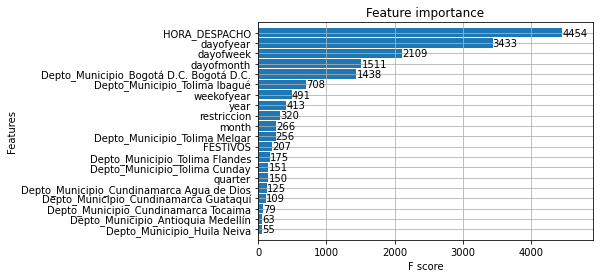

In [78]:
# Evaluate the model

xgb.plot_importance(model_girardot, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_girardot = model_girardot.predict(x_train_girardot)
print('R2 train',r2_score(y_train_girardot,predtrain_girardot))
print('MSE train',mean_squared_error(y_train_girardot,predtrain_girardot))
print('RMSE train',np.sqrt(mean_squared_error(y_train_girardot,predtrain_girardot)))

predtest_girardot=model_girardot.predict(x_test_girardot)
print('R2 test',r2_score(y_test_girardot,predtest_girardot))
print('MSE test',mean_squared_error(y_test_girardot,predtest_girardot))
print('RMSE test',np.sqrt(mean_squared_error(y_test_girardot,predtest_girardot)))

print('Percentil 99 Passengers',np.percentile(data_girardot['PASAJEROS'],99))

In [79]:
# Export model for dash / plotly
file_name = "xgb_model_girardot.pkl"

# save
pickle.dump(model_girardot, open(file_name, "wb"))

## T.T. DE IBAGUÉ

In [80]:
# 1. Data wrangling

# a. Select the terminal

t_ibague=df[df['TERMINAL'] =='T.T. DE IBAGUÉ']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_ibague=t_ibague.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_ibague = data_ibague.rename(columns={'sum':'PASAJEROS'})

#Create new features

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_ibague['FESTIVOS'] = data_ibague['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

data_ibague['dayofweek'] = data_ibague['FECHA_DESPACHO'].dt.dayofweek
data_ibague['quarter'] = data_ibague['FECHA_DESPACHO'].dt.quarter
data_ibague['month'] = data_ibague['FECHA_DESPACHO'].dt.month
data_ibague['year'] = data_ibague['FECHA_DESPACHO'].dt.year
data_ibague['dayofyear'] = data_ibague['FECHA_DESPACHO'].dt.dayofyear
data_ibague['dayofmonth'] = data_ibague['FECHA_DESPACHO'].dt.day
data_ibague['weekofyear'] = data_ibague['FECHA_DESPACHO'].dt.weekofyear

# se crea una nueva variable que da cuenta de restricciones a la movilidad, 3 corresponde al valor sin restricciones, 0 alta
# restricción de movilidad que es el de periodos iniciales a la pandemia y 1 y 2 periodos posteriores siendo 2 el periodo después
# del inicio de vacunación

data_ibague["restriccion"] = np.where(data_ibague['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_ibague['FECHA_DESPACHO'] > '2020-03-26')&(data_ibague['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_ibague['FECHA_DESPACHO'] >='2020-09-01')&(data_ibague['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_ibague['FECHA_DESPACHO'] >='2021-03-01')&(data_ibague['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Se unicia departamento y municipio de destino en una sola variable

data_ibague["Depto_Municipio"]=data_ibague['DEPARTAMENTO_DESTINO']+' '+data_ibague['MUNICIPIO_DESTINO']


<ipython-input-80-e1ecb195cf54>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_ibague['weekofyear'] = data_ibague['FECHA_DESPACHO'].dt.weekofyear


In [81]:
# Ejecución del modelo

# Set x, y
x_ibague=data_ibague.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_ibague=data_ibague['PASAJEROS']

# Encoding categorical data
x_ibague_encoded=pd.get_dummies(x_ibague, columns=["Depto_Municipio"])

# Data training and data test
x_train_ibague, x_test_ibague, y_train_ibague, y_test_ibague = train_test_split(x_ibague_encoded,y_ibague,test_size=0.2,random_state=42)
print(x_train_ibague.shape)
print(x_test_ibague.shape)

# define model
model_ibague = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_ibague.fit(x_train_ibague, y_train_ibague)


(165933, 63)
(41484, 63)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.87408225154166
MSE train 110.65588645103811
RMSE train 10.519310169922651
R2 test 0.8448583214899269
MSE test 137.10699724811332
RMSE test 11.709269714551516
Percentil 99 Passengers 154.0


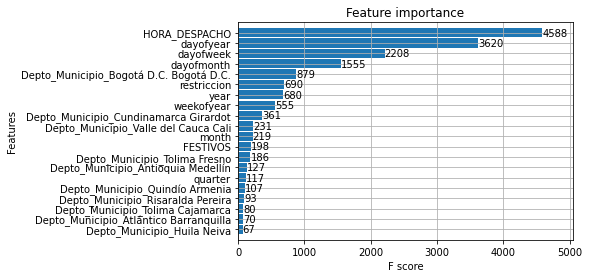

In [82]:
# Evaluate the model

xgb.plot_importance(model_ibague, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_ibague = model_ibague.predict(x_train_ibague)
print('R2 train',r2_score(y_train_ibague,predtrain_ibague))
print('MSE train',mean_squared_error(y_train_ibague,predtrain_ibague))
print('RMSE train',np.sqrt(mean_squared_error(y_train_ibague,predtrain_ibague)))

predtest_ibague=model_ibague.predict(x_test_ibague)
print('R2 test',r2_score(y_test_ibague,predtest_ibague))
print('MSE test',mean_squared_error(y_test_ibague,predtest_ibague))
print('RMSE test',np.sqrt(mean_squared_error(y_test_ibague,predtest_ibague)))

print('Percentil 99 Passengers',np.percentile(data_ibague['PASAJEROS'],99))

In [83]:
# Export model for dash / plotly
file_name = "xgb_model_ibague.pkl"

# save
pickle.dump(model_ibague, open(file_name, "wb"))

## T.T. DE IPIALES

In [84]:
# 1. Data wrangling

# a. Select the terminal
t_ipiales=df[df['TERMINAL'] =='T.T. DE IPIALES']

# b. Select the main features for the model
# Features such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_ipiales=t_ipiales.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_ipiales = data_ipiales.rename(columns={'sum':'PASAJEROS'})

#Create new features

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_ipiales['FESTIVOS'] = data_ipiales['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

data_ipiales['dayofweek'] = data_ipiales['FECHA_DESPACHO'].dt.dayofweek
data_ipiales['quarter'] = data_ipiales['FECHA_DESPACHO'].dt.quarter
data_ipiales['month'] = data_ipiales['FECHA_DESPACHO'].dt.month
data_ipiales['year'] = data_ipiales['FECHA_DESPACHO'].dt.year
data_ipiales['dayofyear'] = data_ipiales['FECHA_DESPACHO'].dt.dayofyear
data_ipiales['dayofmonth'] = data_ipiales['FECHA_DESPACHO'].dt.day
data_ipiales['weekofyear'] = data_ipiales['FECHA_DESPACHO'].dt.weekofyear

# se crea una nueva variable que da cuenta de restricciones a la movilidad, 3 corresponde al valor sin restricciones, 0 alta
# restricción de movilidad que es el de periodos iniciales a la pandemia y 1 y 2 periodos posteriores siendo 2 el periodo después
# del inicio de vacunación

data_ipiales["restriccion"] = np.where(data_ipiales['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_ipiales['FECHA_DESPACHO'] > '2020-03-26')&(data_ipiales['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_ipiales['FECHA_DESPACHO'] >='2020-09-01')&(data_ipiales['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_ipiales['FECHA_DESPACHO'] >='2021-03-01')&(data_ipiales['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Se unicia departamento y municipio de destino en una sola variable

data_ipiales["Depto_Municipio"]=data_ipiales['DEPARTAMENTO_DESTINO']+' '+data_ipiales['MUNICIPIO_DESTINO']


<ipython-input-84-073482418a76>:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_ipiales['weekofyear'] = data_ipiales['FECHA_DESPACHO'].dt.weekofyear


In [85]:
# Ejecución del modelo

# Set x, y
x_ipiales=data_ipiales.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_ipiales=data_ipiales['PASAJEROS']

# Encoding categorical data
x_ipiales_encoded=pd.get_dummies(x_ipiales, columns=["Depto_Municipio"])

# Data training and data test
x_train_ipiales, x_test_ipiales, y_train_ipiales, y_test_ipiales = train_test_split(x_ipiales_encoded,y_ipiales,test_size=0.2,random_state=42)
print(x_train_ipiales.shape)
print(x_test_ipiales.shape)

# define model
model_ipiales = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_ipiales.fit(x_train_ipiales, y_train_ipiales)


(64612, 36)
(16153, 36)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.8737306844037298
MSE train 112.91513967870557
RMSE train 10.626153569316866
R2 test 0.7660517665078423
MSE test 216.45748158786827
RMSE test 14.712494064157452
Percentil 99 Passengers 147.0


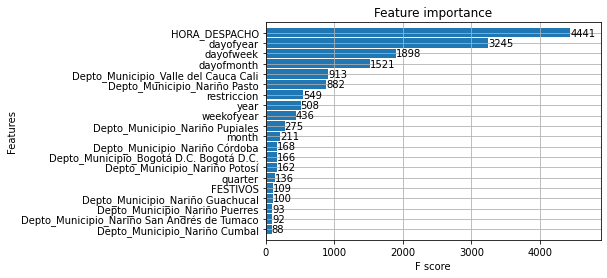

In [86]:
# Evaluate the model

xgb.plot_importance(model_ipiales, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_ipiales = model_ipiales.predict(x_train_ipiales)
print('R2 train',r2_score(y_train_ipiales,predtrain_ipiales))
print('MSE train',mean_squared_error(y_train_ipiales,predtrain_ipiales))
print('RMSE train',np.sqrt(mean_squared_error(y_train_ipiales,predtrain_ipiales)))

predtest_ipiales=model_ipiales.predict(x_test_ipiales)
print('R2 test',r2_score(y_test_ipiales,predtest_ipiales))
print('MSE test',mean_squared_error(y_test_ipiales,predtest_ipiales))
print('RMSE test',np.sqrt(mean_squared_error(y_test_ipiales,predtest_ipiales)))

print('Percentil 99 Passengers',np.percentile(data_ipiales['PASAJEROS'],99))

In [87]:
# Export model for dash / plotly

file_name = "xgb_model_ipiales.pkl"

# save
pickle.dump(model_ipiales, open(file_name, "wb"))

## Overfitting treatment

In [92]:
## Overfitting is treated with data aumentation and regularization of hyperparameters

## Params definition
params = {"learning_rate": [0.1,0.01,0.05, 0.10, 0.15, 0.20, 0.25, 0.30], # Giving some ones parameters to perform on randomized search and obtain the better combination
         "max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
         "min_child_weight": [1, 3, 5, 7],
         "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
         "colsample_bytree": [0.3, 0.4, 0.5, 0.7]}
#         "n_estimator": [80,100,120,140,160,180,200]}

## Terminals with overfitting

# T.T. DE AGUACHICA

In [88]:
# 1. Data wrangling

# a. Select the terminal

t_aguachica=df[df['TERMINAL'] =='T.T. DE AGUACHICA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_aguachica=t_aguachica.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_aguachica = data_aguachica.rename(columns={'sum':'PASAJEROS'})

#Create new features

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_aguachica['FESTIVOS'] = data_aguachica['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

data_aguachica['dayofweek'] = data_aguachica['FECHA_DESPACHO'].dt.dayofweek
data_aguachica['quarter'] = data_aguachica['FECHA_DESPACHO'].dt.quarter
data_aguachica['month'] = data_aguachica['FECHA_DESPACHO'].dt.month
data_aguachica['year'] = data_aguachica['FECHA_DESPACHO'].dt.year
data_aguachica['dayofyear'] = data_aguachica['FECHA_DESPACHO'].dt.dayofyear
data_aguachica['dayofmonth'] = data_aguachica['FECHA_DESPACHO'].dt.day
data_aguachica['weekofyear'] = data_aguachica['FECHA_DESPACHO'].dt.weekofyear

# se crea una nueva variable que da cuenta de restricciones a la movilidad, 3 corresponde al valor sin restricciones, 0 alta
# restricción de movilidad que es el de periodos iniciales a la pandemia y 1 y 2 periodos posteriores siendo 2 el periodo después
# del inicio de vacunación

data_aguachica["restriccion"] = np.where(data_aguachica['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_aguachica['FECHA_DESPACHO'] > '2020-03-26')&(data_aguachica['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_aguachica['FECHA_DESPACHO'] >='2020-09-01')&(data_aguachica['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_aguachica['FECHA_DESPACHO'] >='2021-03-01')&(data_aguachica['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Se unicia departamento y municipio de destino en una sola variable

data_aguachica["Depto_Municipio"]=data_aguachica['DEPARTAMENTO_DESTINO']+' '+data_aguachica['MUNICIPIO_DESTINO']


<ipython-input-88-03629ff424b6>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_aguachica['weekofyear'] = data_aguachica['FECHA_DESPACHO'].dt.weekofyear


In [89]:
# Ejecución del modelo

# Set x, y
x_aguachica=data_aguachica.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_aguachica=data_aguachica['PASAJEROS']

# Encoding categorical data
x_aguachica_encoded=pd.get_dummies(x_aguachica, columns=["Depto_Municipio"])

# Data training and data test
x_train_aguachica, x_test_aguachica, y_train_aguachica, y_test_aguachica = train_test_split(x_aguachica_encoded,y_aguachica,test_size=0.2,random_state=42)
print(x_train_aguachica.shape)
print(x_test_aguachica.shape)

# define model
model_aguachica = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_aguachica.fit(x_train_aguachica, y_train_aguachica)

(49939, 33)
(12485, 33)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.6747053554377617
MSE train 23.666151183759304
RMSE train 4.864786859026745
R2 test 0.45945238201107486
MSE test 42.05716091209618
RMSE test 6.485149259045329
Percentil 99 Passengers 41.0


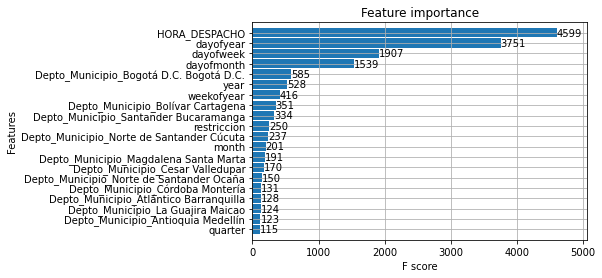

In [90]:
# Evaluate the model

xgb.plot_importance(model_aguachica, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_aguachica = model_aguachica.predict(x_train_aguachica)
print('R2 train',r2_score(y_train_aguachica,predtrain_aguachica))
print('MSE train',mean_squared_error(y_train_aguachica,predtrain_aguachica))
print('RMSE train',np.sqrt(mean_squared_error(y_train_aguachica,predtrain_aguachica)))

predtest_aguachica=model_aguachica.predict(x_test_aguachica)
print('R2 test',r2_score(y_test_aguachica,predtest_aguachica))
print('MSE test',mean_squared_error(y_test_aguachica,predtest_aguachica))
print('RMSE test',np.sqrt(mean_squared_error(y_test_aguachica,predtest_aguachica)))

print('Percentil 99 Passengers',np.percentile(data_aguachica['PASAJEROS'],99))

In [93]:
## Find best hyperparameters for regularization

model_aguachica2= XGBRegressor(objective ='reg:squarederror', seed = 123)
random_search_aguachica = RandomizedSearchCV(model_aguachica2, param_distributions=params, n_iter=5, scoring='r2', n_jobs=-1, cv=5, 
                                   verbose=3)

random_search_aguachica.fit(x_train_aguachica, y_train_aguachica)
print(random_search_aguachica.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.4, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.15, max_delta_step=0, max_depth=6,
             min_child_weight=7, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)


R2 train 0.5347480420340562
MSE train 34.12748752011541
RMSE train 5.841873630960825
R2 test 0.3943748131470497
MSE test 45.25003565290969
RMSE test 6.72681467359624
Percentil 99 Passengers 41.0


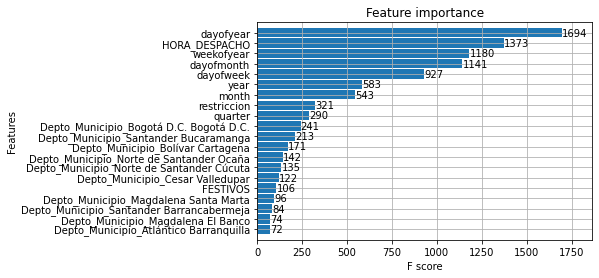

In [173]:
## run again the model with the best estimators of hyperparameters and evaluate

# Data training and data test
x_train_aguachica, x_test_aguachica, y_train_aguachica, y_test_aguachica = train_test_split(x_aguachica_encoded,y_aguachica,
                                                                                            test_size=0.3,random_state=42)
# define model
model_aguachica2 = XGBRegressor(objective ='reg:squarederror', seed = 123,base_score=0.5, booster='gbtree', 
                                colsample_bylevel=1,colsample_bynode=1, colsample_bytree=0.5, gamma=0.4, gpu_id=-1,
                                importance_type='gain', interaction_constraints='',learning_rate=0.25, 
                                max_delta_step=0, max_depth=7,min_child_weight=7, n_estimators=120, n_jobs=2, 
                                num_parallel_tree=1, random_state=123,reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
                                subsample=1, tree_method='exact', validate_parameters=1,
                                verbosity=None)

# fit model
model_aguachica2.fit(x_train_aguachica, y_train_aguachica)

# Evaluate the model

xgb.plot_importance(model_aguachica2, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_aguachica = model_aguachica2.predict(x_train_aguachica)
print('R2 train',r2_score(y_train_aguachica,predtrain_aguachica))
print('MSE train',mean_squared_error(y_train_aguachica,predtrain_aguachica))
print('RMSE train',np.sqrt(mean_squared_error(y_train_aguachica,predtrain_aguachica)))

predtest_aguachica=model_aguachica2.predict(x_test_aguachica)
print('R2 test',r2_score(y_test_aguachica,predtest_aguachica))
print('MSE test',mean_squared_error(y_test_aguachica,predtest_aguachica))
print('RMSE test',np.sqrt(mean_squared_error(y_test_aguachica,predtest_aguachica)))

print('Percentil 99 Passengers',np.percentile(data_aguachica['PASAJEROS'],99))

In [174]:
# Export model for dash / plotly
file_name = "xgb_model_aguachica.pkl"

# save
pickle.dump(model_aguachica2, open(file_name, "wb"))

# T.T. DE AGUAZUL

In [95]:
# 1. Data wrangling

# a. Select the terminal

t_aguazul=df[df['TERMINAL'] =='T.T. DE AGUAZUL']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_aguazul=t_aguazul.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_aguazul = data_aguazul.rename(columns={'sum':'PASAJEROS'})

#Create new features

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_aguazul['FESTIVOS'] = data_aguazul['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

data_aguazul['dayofweek'] = data_aguazul['FECHA_DESPACHO'].dt.dayofweek
data_aguazul['quarter'] = data_aguazul['FECHA_DESPACHO'].dt.quarter
data_aguazul['month'] = data_aguazul['FECHA_DESPACHO'].dt.month
data_aguazul['year'] = data_aguazul['FECHA_DESPACHO'].dt.year
data_aguazul['dayofyear'] = data_aguazul['FECHA_DESPACHO'].dt.dayofyear
data_aguazul['dayofmonth'] = data_aguazul['FECHA_DESPACHO'].dt.day
data_aguazul['weekofyear'] = data_aguazul['FECHA_DESPACHO'].dt.weekofyear

# se crea una nueva variable que da cuenta de restricciones a la movilidad, 3 corresponde al valor sin restricciones, 0 alta
# restricción de movilidad que es el de periodos iniciales a la pandemia y 1 y 2 periodos posteriores siendo 2 el periodo después
# del inicio de vacunación

data_aguazul["restriccion"] = np.where(data_aguazul['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_aguazul['FECHA_DESPACHO'] > '2020-03-26')&(data_aguazul['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_aguazul['FECHA_DESPACHO'] >='2020-09-01')&(data_aguazul['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_aguazul['FECHA_DESPACHO'] >='2021-03-01')&(data_aguazul['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Se unicia departamento y municipio de destino en una sola variable

data_aguazul["Depto_Municipio"]=data_aguazul['DEPARTAMENTO_DESTINO']+' '+data_aguazul['MUNICIPIO_DESTINO']


<ipython-input-95-4f12e31f3f62>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_aguazul['weekofyear'] = data_aguazul['FECHA_DESPACHO'].dt.weekofyear


In [96]:
# Ejecución del modelo

# Set x, y
x_aguazul=data_aguazul.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_aguazul=data_aguazul['PASAJEROS']

# Encoding categorical data
x_aguazul_encoded=pd.get_dummies(x_aguazul, columns=["Depto_Municipio"])

# Data training and data test
x_train_aguazul, x_test_aguazul, y_train_aguazul, y_test_aguazul = train_test_split(x_aguazul_encoded,y_aguazul,test_size=0.2,random_state=42)
print(x_train_aguazul.shape)
print(x_test_aguazul.shape)

# define model
model_aguazul = XGBRegressor(objective ='reg:squarederror', n_estimators = 500, seed = 123)

# fit model
model_aguazul.fit(x_train_aguazul, y_train_aguazul)


(50382, 28)
(12596, 28)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.8362789994395927
MSE train 38.60592115353806
RMSE train 6.213366330222134
R2 test 0.581594505376144
MSE test 92.92043157636995
RMSE test 9.639524447625513
Percentil 99 Passengers 73.0


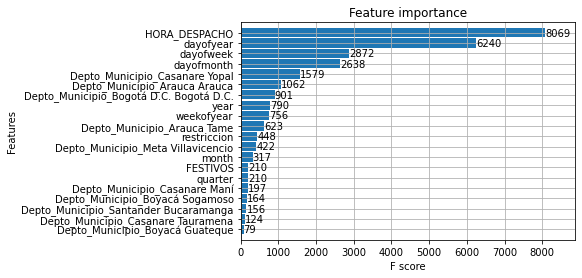

In [97]:
# Evaluate the model

xgb.plot_importance(model_aguazul, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_aguazul = model_aguazul.predict(x_train_aguazul)
print('R2 train',r2_score(y_train_aguazul,predtrain_aguazul))
print('MSE train',mean_squared_error(y_train_aguazul,predtrain_aguazul))
print('RMSE train',np.sqrt(mean_squared_error(y_train_aguazul,predtrain_aguazul)))

predtest_aguazul=model_aguazul.predict(x_test_aguazul)
print('R2 test',r2_score(y_test_aguazul,predtest_aguazul))
print('MSE test',mean_squared_error(y_test_aguazul,predtest_aguazul))
print('RMSE test',np.sqrt(mean_squared_error(y_test_aguazul,predtest_aguazul)))

print('Percentil 99 Passengers',np.percentile(data_aguazul['PASAJEROS'],99))

In [98]:
# Data training and data test
x_train_aguazul, x_test_aguazul, y_train_aguazul, y_test_aguazul = train_test_split(x_aguazul_encoded,y_aguazul,test_size=0.3,random_state=42) 

## Find best hyperparameters for regularization
model_aguazul2= XGBRegressor(objective ='reg:squarederror', seed = 123)
random_search_aguazul = RandomizedSearchCV(model_aguazul2, param_distributions=params, n_iter=5, scoring='r2', n_jobs=-1, cv=5, 
                                   verbose=3)

random_search_aguazul.fit(x_train_aguazul, y_train_aguazul)
print(random_search_aguazul.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)


[03:18:07] WARNING: ../src/learner.cc:573: 
Parameters: { "n_estimator" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


R2 train 0.6449744737963862
MSE train 84.24669294305536
RMSE train 9.178599726704253
R2 test 0.5849055866965518
MSE test 92.63097179210149
RMSE test 9.624498521590695
Percentil 99 Passengers 73.0


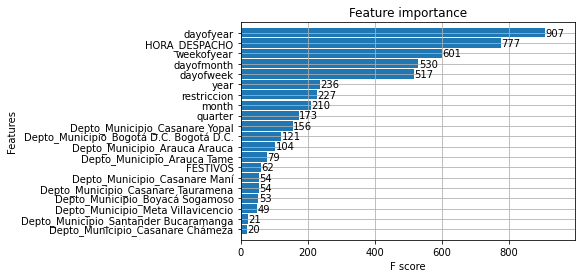

In [99]:
## run again the model with the best estimators of hyperparameters and evaluate

# define model
model_aguazul2 = XGBRegressor(objective ='reg:squarederror', seed = 123,base_score=0.5, booster='gbtree', colsample_bylevel=1,
                              colsample_bynode=1, colsample_bytree=0.5, gamma=0.4, gpu_id=-1,
                              importance_type='gain', interaction_constraints='',
                              learning_rate=0.25, max_delta_step=0, max_depth=6,
                              min_child_weight=5, n_estimator=100, n_jobs=2, num_parallel_tree=1,
                              random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact', validate_parameters=1,
                              verbosity=None)

# fit model
model_aguazul2.fit(x_train_aguazul, y_train_aguazul)

# Evaluate the model

xgb.plot_importance(model_aguazul2, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_aguazul = model_aguazul2.predict(x_train_aguazul)
print('R2 train',r2_score(y_train_aguazul,predtrain_aguazul))
print('MSE train',mean_squared_error(y_train_aguazul,predtrain_aguazul))
print('RMSE train',np.sqrt(mean_squared_error(y_train_aguazul,predtrain_aguazul)))

predtest_aguazul=model_aguazul2.predict(x_test_aguazul)
print('R2 test',r2_score(y_test_aguazul,predtest_aguazul))
print('MSE test',mean_squared_error(y_test_aguazul,predtest_aguazul))
print('RMSE test',np.sqrt(mean_squared_error(y_test_aguazul,predtest_aguazul)))

print('Percentil 99 Passengers',np.percentile(data_aguazul['PASAJEROS'],99))

In [100]:
# Export model for dash / plotly
file_name = "xgb_model_aguazul.pkl"

# save
pickle.dump(model_aguazul2, open(file_name, "wb"))

## T.T. DE BUENAVENTURA

In [101]:
# 1. Data wrangling

# a. Select the terminal
t_buenaventura=df[df['TERMINAL'] =='T.T. DE BUENAVENTURA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_buenaventura=t_buenaventura.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_buenaventura = data_buenaventura.rename(columns={'sum':'PASAJEROS'})

#Create new features

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_buenaventura['FESTIVOS'] = data_buenaventura['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

data_buenaventura['dayofweek'] = data_buenaventura['FECHA_DESPACHO'].dt.dayofweek
data_buenaventura['quarter'] = data_buenaventura['FECHA_DESPACHO'].dt.quarter
data_buenaventura['month'] = data_buenaventura['FECHA_DESPACHO'].dt.month
data_buenaventura['year'] = data_buenaventura['FECHA_DESPACHO'].dt.year
data_buenaventura['dayofyear'] = data_buenaventura['FECHA_DESPACHO'].dt.dayofyear
data_buenaventura['dayofmonth'] = data_buenaventura['FECHA_DESPACHO'].dt.day
data_buenaventura['weekofyear'] = data_buenaventura['FECHA_DESPACHO'].dt.weekofyear

# se crea una nueva variable que da cuenta de restricciones a la movilidad, 3 corresponde al valor sin restricciones, 0 alta
# restricción de movilidad que es el de periodos iniciales a la pandemia y 1 y 2 periodos posteriores siendo 2 el periodo después
# del inicio de vacunación

data_buenaventura["restriccion"] = np.where(data_buenaventura['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_buenaventura['FECHA_DESPACHO'] > '2020-03-26')&(data_buenaventura['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_buenaventura['FECHA_DESPACHO'] >='2020-09-01')&(data_buenaventura['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_buenaventura['FECHA_DESPACHO'] >='2021-03-01')&(data_buenaventura['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Se unicia departamento y municipio de destino en una sola variable

data_buenaventura["Depto_Municipio"]=data_buenaventura['DEPARTAMENTO_DESTINO']+' '+data_buenaventura['MUNICIPIO_DESTINO']


<ipython-input-101-85a8fd84fa26>:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_buenaventura['weekofyear'] = data_buenaventura['FECHA_DESPACHO'].dt.weekofyear


In [102]:
# Ejecución del modelo

# Set x, y
x_buenaventura=data_buenaventura.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_buenaventura=data_buenaventura['PASAJEROS']

# Encoding categorical data
x_buenaventura_encoded=pd.get_dummies(x_buenaventura, columns=["Depto_Municipio"])

# Data training and data test
x_train_buenaventura, x_test_buenaventura, y_train_buenaventura, y_test_buenaventura = train_test_split(x_buenaventura_encoded,y_buenaventura,test_size=0.2,random_state=42)
print(x_train_buenaventura.shape)
print(x_test_buenaventura.shape)

# define model
model_buenaventura = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_buenaventura.fit(x_train_buenaventura, y_train_buenaventura)


(13735, 21)
(3434, 21)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.9063616671375998
MSE train 34.002447863949406
RMSE train 5.831161793669372
R2 test 0.6021454688635541
MSE test 131.51776928584957
RMSE test 11.468119692689363
Percentil 99 Passengers 85.0


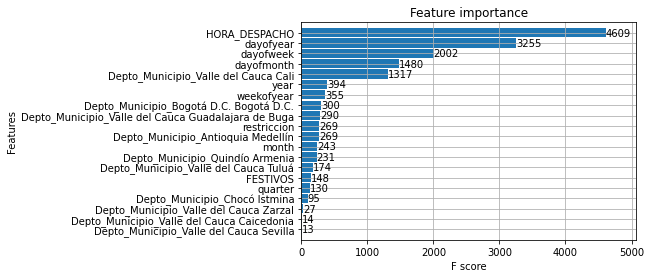

In [103]:
# Evaluate the model

xgb.plot_importance(model_buenaventura, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_buenaventura = model_buenaventura.predict(x_train_buenaventura)
print('R2 train',r2_score(y_train_buenaventura,predtrain_buenaventura))
print('MSE train',mean_squared_error(y_train_buenaventura,predtrain_buenaventura))
print('RMSE train',np.sqrt(mean_squared_error(y_train_buenaventura,predtrain_buenaventura)))

predtest_buenaventura=model_buenaventura.predict(x_test_buenaventura)
print('R2 test',r2_score(y_test_buenaventura,predtest_buenaventura))
print('MSE test',mean_squared_error(y_test_buenaventura,predtest_buenaventura))
print('RMSE test',np.sqrt(mean_squared_error(y_test_buenaventura,predtest_buenaventura)))

print('Percentil 99 Passengers',np.percentile(data_buenaventura['PASAJEROS'],99))

In [104]:
## Find best hyperparameters for regularization

# Data training and data test
x_train_buenaventura, x_test_buenaventura, y_train_buenaventura, y_test_buenaventura = train_test_split(x_buenaventura_encoded,y_buenaventura,test_size=0.3,random_state=42) 

## Find best hyperparameters for regularization
model_buenaventura2= XGBRegressor(objective ='reg:squarederror', seed = 123)
random_search_buenaventura = RandomizedSearchCV(model_buenaventura2, param_distributions=params, n_iter=5, scoring='r2', n_jobs=-1, cv=5, 
                                   verbose=3)

random_search_buenaventura.fit(x_train_buenaventura, y_train_buenaventura)
print(random_search_buenaventura.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.4, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=15,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)


[03:34:18] WARNING: ../src/learner.cc:573: 
Parameters: { "n_estimator" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


R2 train 0.8245267178691096
MSE train 63.60756543126004
RMSE train 7.975435124885666
R2 test 0.6956497959017338
MSE test 104.37261957189808
RMSE test 10.216291869944696
Percentil 99 Passengers 85.0


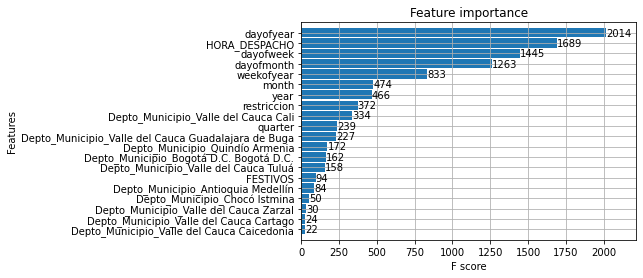

In [105]:
## run again the model with the best estimators of hyperparameters and evaluate

# define model
model_buenaventura2 = XGBRegressor(objective ='reg:squarederror', seed = 123,base_score=0.5, booster='gbtree', 
                                   colsample_bylevel=1,colsample_bynode=1, colsample_bytree=0.7, gamma=0.0, gpu_id=-1,
                                   importance_type='gain', interaction_constraints='',
                                   learning_rate=0.15, max_delta_step=0, max_depth=8,
                                   min_child_weight=5,n_estimator=120, n_jobs=2, num_parallel_tree=1,
                                   random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                                   subsample=1, tree_method='exact', validate_parameters=1,
                                   verbosity=None)

# fit model
model_buenaventura2.fit(x_train_buenaventura, y_train_buenaventura)

# Evaluate the model

xgb.plot_importance(model_buenaventura2, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_buenaventura = model_buenaventura2.predict(x_train_buenaventura)
print('R2 train',r2_score(y_train_buenaventura,predtrain_buenaventura))
print('MSE train',mean_squared_error(y_train_buenaventura,predtrain_buenaventura))
print('RMSE train',np.sqrt(mean_squared_error(y_train_buenaventura,predtrain_buenaventura)))

predtest_buenaventura=model_buenaventura2.predict(x_test_buenaventura)
print('R2 test',r2_score(y_test_buenaventura,predtest_buenaventura))
print('MSE test',mean_squared_error(y_test_buenaventura,predtest_buenaventura))
print('RMSE test',np.sqrt(mean_squared_error(y_test_buenaventura,predtest_buenaventura)))

print('Percentil 99 Passengers',np.percentile(data_buenaventura['PASAJEROS'],99))

In [106]:
# Export model for dash / plotly
file_name = "xgb_model_buenaventura.pkl"

# save
pickle.dump(model_buenaventura2, open(file_name, "wb"))

## T.T. DE CAUCASIA

In [107]:
# 1. Data wrangling

# a. Select the terminal

t_caucasia=df[df['TERMINAL'] =='T.T. DE CAUCASIA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_caucasia=t_caucasia.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_caucasia = data_caucasia.rename(columns={'sum':'PASAJEROS'})

#Create new features

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_caucasia['FESTIVOS'] = data_caucasia['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

data_caucasia['dayofweek'] = data_caucasia['FECHA_DESPACHO'].dt.dayofweek
data_caucasia['quarter'] = data_caucasia['FECHA_DESPACHO'].dt.quarter
data_caucasia['month'] = data_caucasia['FECHA_DESPACHO'].dt.month
data_caucasia['year'] = data_caucasia['FECHA_DESPACHO'].dt.year
data_caucasia['dayofyear'] = data_caucasia['FECHA_DESPACHO'].dt.dayofyear
data_caucasia['dayofmonth'] = data_caucasia['FECHA_DESPACHO'].dt.day
data_caucasia['weekofyear'] = data_caucasia['FECHA_DESPACHO'].dt.weekofyear

# se crea una nueva variable que da cuenta de restricciones a la movilidad, 3 corresponde al valor sin restricciones, 0 alta
# restricción de movilidad que es el de periodos iniciales a la pandemia y 1 y 2 periodos posteriores siendo 2 el periodo después
# del inicio de vacunación

data_caucasia["restriccion"] = np.where(data_caucasia['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_caucasia['FECHA_DESPACHO'] > '2020-03-26')&(data_caucasia['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_caucasia['FECHA_DESPACHO'] >='2020-09-01')&(data_caucasia['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_caucasia['FECHA_DESPACHO'] >='2021-03-01')&(data_caucasia['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Se unicia departamento y municipio de destino en una sola variable

data_caucasia["Depto_Municipio"]=data_caucasia['DEPARTAMENTO_DESTINO']+' '+data_caucasia['MUNICIPIO_DESTINO']


<ipython-input-107-5a177bd38f62>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_caucasia['weekofyear'] = data_caucasia['FECHA_DESPACHO'].dt.weekofyear


In [108]:
# Ejecución del modelo

# Set x, y
x_caucasia=data_caucasia.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_caucasia=data_caucasia['PASAJEROS']

# Encoding categorical data
x_caucasia_encoded=pd.get_dummies(x_caucasia, columns=["Depto_Municipio"])

# Data training and data test
x_train_caucasia, x_test_caucasia, y_train_caucasia, y_test_caucasia = train_test_split(x_caucasia_encoded,y_caucasia,test_size=0.2,random_state=42)
print(x_train_caucasia.shape)
print(x_test_caucasia.shape)

# define model
model_caucasia = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_caucasia.fit(x_train_caucasia, y_train_caucasia)


(50244, 34)
(12561, 34)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.7669844893668007
MSE train 23.67685544153132
RMSE train 4.865886912119035
R2 test 0.5718822980033464
MSE test 41.087050887806974
RMSE test 6.409918165453204
Percentil 99 Passengers 48.0


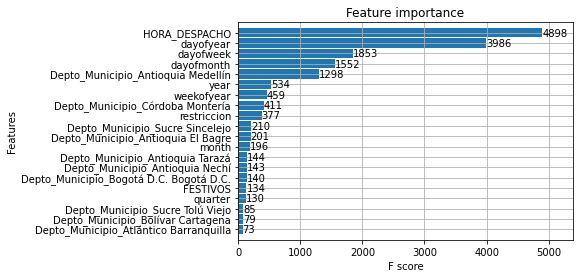

In [109]:
# Evaluate the model

xgb.plot_importance(model_caucasia, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_caucasia = model_caucasia.predict(x_train_caucasia)
print('R2 train',r2_score(y_train_caucasia,predtrain_caucasia))
print('MSE train',mean_squared_error(y_train_caucasia,predtrain_caucasia))
print('RMSE train',np.sqrt(mean_squared_error(y_train_caucasia,predtrain_caucasia)))

predtest_caucasia=model_caucasia.predict(x_test_caucasia)
print('R2 test',r2_score(y_test_caucasia,predtest_caucasia))
print('MSE test',mean_squared_error(y_test_caucasia,predtest_caucasia))
print('RMSE test',np.sqrt(mean_squared_error(y_test_caucasia,predtest_caucasia)))

print('Percentil 99 Passengers',np.percentile(data_caucasia['PASAJEROS'],99))

In [110]:
## Find best hyperparameters for regularization

# Data training and data test
x_train_caucasia, x_test_caucasia, y_train_caucasia, y_test_caucasia = train_test_split(x_caucasia_encoded,y_caucasia,test_size=0.3,random_state=42) 

## Find best hyperparameters for regularization
model_caucasia2= XGBRegressor(objective ='reg:squarederror', seed = 123)
random_search_caucasia = RandomizedSearchCV(model_caucasia2, param_distributions=params, n_iter=5, scoring='r2', n_jobs=-1, cv=5, 
                                   verbose=3)

random_search_caucasia.fit(x_train_caucasia, y_train_caucasia)
print(random_search_caucasia.best_estimator_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.3, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=5,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)


R2 train 0.559817143917205
MSE train 45.24415380536146
RMSE train 6.726377465275157
R2 test 0.5227556587235067
MSE test 45.3894637766744
RMSE test 6.737170309311944
Percentil 99 Passengers 48.0


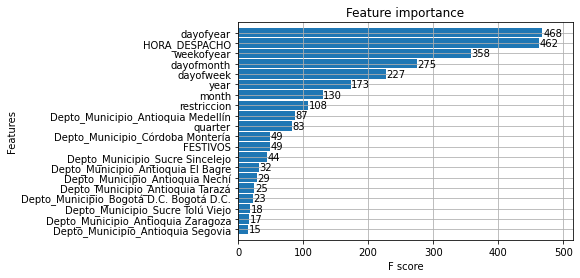

In [160]:
## run again the model with the best estimators of hyperparameters and evaluate

# define model
model_caucasia2 = XGBRegressor(objective ='reg:squarederror', seed = 123,base_score=0.5, booster='gbtree', 
                               colsample_bylevel=1,colsample_bynode=1, colsample_bytree=0.5, gamma=0.3, gpu_id=-1,
                               importance_type='gain', interaction_constraints='',
                               learning_rate=0.2, max_delta_step=0, max_depth=5,
                               min_child_weight=5, n_estimators=100, n_jobs=2, num_parallel_tree=1, 
                               random_state=123,reg_alpha=0, reg_lambda=1, scale_pos_weight=1,subsample=1, 
                               tree_method='exact', validate_parameters=1,verbosity=None)

# fit model
model_caucasia2.fit(x_train_caucasia, y_train_caucasia)

# Evaluate the model

xgb.plot_importance(model_caucasia2, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_caucasia = model_caucasia2.predict(x_train_caucasia)
print('R2 train',r2_score(y_train_caucasia,predtrain_caucasia))
print('MSE train',mean_squared_error(y_train_caucasia,predtrain_caucasia))
print('RMSE train',np.sqrt(mean_squared_error(y_train_caucasia,predtrain_caucasia)))

predtest_caucasia=model_caucasia2.predict(x_test_caucasia)
print('R2 test',r2_score(y_test_caucasia,predtest_caucasia))
print('MSE test',mean_squared_error(y_test_caucasia,predtest_caucasia))
print('RMSE test',np.sqrt(mean_squared_error(y_test_caucasia,predtest_caucasia)))

print('Percentil 99 Passengers',np.percentile(data_caucasia['PASAJEROS'],99))

In [161]:
# Export model for dash / plotly
file_name = "xgb_model_caucasia.pkl"

# save
pickle.dump(model_caucasia2, open(file_name, "wb"))

## T.T. DE LA PLATA

In [112]:
# 1. Data wrangling

# a. Select the terminal

t_laplata=df[df['TERMINAL'] =='T.T. DE LA PLATA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_laplata=t_laplata.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_laplata = data_laplata.rename(columns={'sum':'PASAJEROS'})

#Create new features

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_laplata['FESTIVOS'] = data_laplata['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

data_laplata['dayofweek'] = data_laplata['FECHA_DESPACHO'].dt.dayofweek
data_laplata['quarter'] = data_laplata['FECHA_DESPACHO'].dt.quarter
data_laplata['month'] = data_laplata['FECHA_DESPACHO'].dt.month
data_laplata['year'] = data_laplata['FECHA_DESPACHO'].dt.year
data_laplata['dayofyear'] = data_laplata['FECHA_DESPACHO'].dt.dayofyear
data_laplata['dayofmonth'] = data_laplata['FECHA_DESPACHO'].dt.day
data_laplata['weekofyear'] = data_laplata['FECHA_DESPACHO'].dt.weekofyear

# se crea una nueva variable que da cuenta de restricciones a la movilidad, 3 corresponde al valor sin restricciones, 0 alta
# restricción de movilidad que es el de periodos iniciales a la pandemia y 1 y 2 periodos posteriores siendo 2 el periodo después
# del inicio de vacunación

data_laplata["restriccion"] = np.where(data_laplata['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_laplata['FECHA_DESPACHO'] > '2020-03-26')&(data_laplata['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_laplata['FECHA_DESPACHO'] >='2020-09-01')&(data_laplata['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_laplata['FECHA_DESPACHO'] >='2021-03-01')&(data_laplata['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Se unicia departamento y municipio de destino en una sola variable

data_laplata["Depto_Municipio"]=data_laplata['DEPARTAMENTO_DESTINO']+' '+data_laplata['MUNICIPIO_DESTINO']


<ipython-input-112-08f60d8bc658>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_laplata['weekofyear'] = data_laplata['FECHA_DESPACHO'].dt.weekofyear


In [113]:
# Ejecución del modelo

# Set x, y
x_laplata=data_laplata.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_laplata=data_laplata['PASAJEROS']

# Encoding categorical data
x_laplata_encoded=pd.get_dummies(x_laplata, columns=["Depto_Municipio"])

# Data training and data test
x_train_laplata, x_test_laplata, y_train_laplata, y_test_laplata = train_test_split(x_laplata_encoded,y_laplata,test_size=0.2,random_state=42)
print(x_train_laplata.shape)
print(x_test_laplata.shape)

# define model
model_laplata = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_laplata.fit(x_train_laplata, y_train_laplata)


(28629, 29)
(7158, 29)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.8038161738322483
MSE train 19.4970770113103
RMSE train 4.415549457463963
R2 test 0.498087434978403
MSE test 45.653792503715366
RMSE test 6.756759023652935
Percentil 99 Passengers 47.0


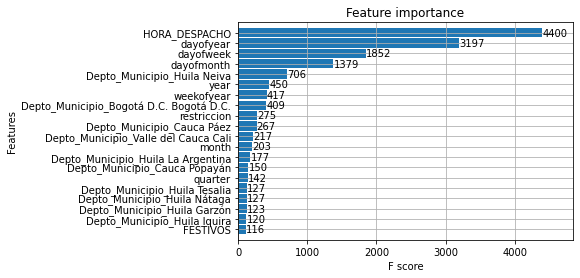

In [114]:
# Evaluate the model

xgb.plot_importance(model_laplata, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_laplata = model_laplata.predict(x_train_laplata)
print('R2 train',r2_score(y_train_laplata,predtrain_laplata))
print('MSE train',mean_squared_error(y_train_laplata,predtrain_laplata))
print('RMSE train',np.sqrt(mean_squared_error(y_train_laplata,predtrain_laplata)))

predtest_laplata=model_laplata.predict(x_test_laplata)
print('R2 test',r2_score(y_test_laplata,predtest_laplata))
print('MSE test',mean_squared_error(y_test_laplata,predtest_laplata))
print('RMSE test',np.sqrt(mean_squared_error(y_test_laplata,predtest_laplata)))

print('Percentil 99 Passengers',np.percentile(data_laplata['PASAJEROS'],99))

In [115]:
## Find best hyperparameters for regularization

# Data training and data test
x_train_laplata, x_test_laplata, y_train_laplata, y_test_laplata = train_test_split(x_laplata_encoded,y_laplata,test_size=0.3,random_state=42) 

## Find best hyperparameters for regularization
model_laplata2= XGBRegressor(objective ='reg:squarederror', seed = 123)
random_search_laplata = RandomizedSearchCV(model_laplata2, param_distributions=params, n_iter=5, scoring='r2', n_jobs=-1, cv=5, 
                                   verbose=3)

random_search_laplata.fit(x_train_laplata, y_train_laplata)
print(random_search_laplata.best_estimator_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.3, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=7, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)


[03:56:08] WARNING: ../src/learner.cc:573: 
Parameters: { "n_estimator" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


R2 train 0.6328765648759924
MSE train 35.64611191306772
RMSE train 5.970436492675198
R2 test 0.5628316010602379
MSE test 43.3265613519344
RMSE test 6.582291497034631
Percentil 99 Passengers 47.0


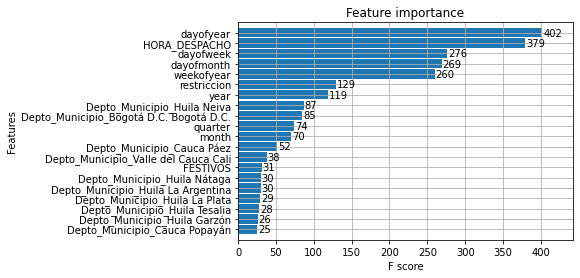

In [116]:
## run again the model with the best estimators of hyperparameters and evaluate

# define model
model_laplata2 = XGBRegressor(objective ='reg:squarederror', seed = 123,base_score=0.5, booster='gbtree', 
                              colsample_bylevel=1,colsample_bynode=1, colsample_bytree=0.5, gamma=0.4, 
                              gpu_id=-1,importance_type='gain', interaction_constraints='',
                              learning_rate=0.25, max_delta_step=0, max_depth=5,min_child_weight=3, 
                              n_estimator=120, n_jobs=2, num_parallel_tree=1,random_state=123, reg_alpha=0, 
                              reg_lambda=1, scale_pos_weight=1,subsample=1, tree_method='exact', validate_parameters=1,
                              verbosity=None)

# fit model
model_laplata2.fit(x_train_laplata, y_train_laplata)

# Evaluate the model

xgb.plot_importance(model_laplata2, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_laplata = model_laplata2.predict(x_train_laplata)
print('R2 train',r2_score(y_train_laplata,predtrain_laplata))
print('MSE train',mean_squared_error(y_train_laplata,predtrain_laplata))
print('RMSE train',np.sqrt(mean_squared_error(y_train_laplata,predtrain_laplata)))

predtest_laplata=model_laplata2.predict(x_test_laplata)
print('R2 test',r2_score(y_test_laplata,predtest_laplata))
print('MSE test',mean_squared_error(y_test_laplata,predtest_laplata))
print('RMSE test',np.sqrt(mean_squared_error(y_test_laplata,predtest_laplata)))

print('Percentil 99 Passengers',np.percentile(data_laplata['PASAJEROS'],99))

In [117]:
# Export model for dash / plotly
file_name = "xgb_model_laplata.pkl"

# save
pickle.dump(model_laplata2, open(file_name, "wb"))